In [2]:
import pathlib

import matplotlib as mpl
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt

output_dir = "../../figures/DE"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
plt.style.use("../../scripts/paper.mplstyle")
sc.settings.figdir = output_dir
sc.set_figure_params(dpi_save=300, figsize=plt.rcParams["figure.figsize"])
sc.set_figure_params(format="pdf", transparent=True)

# adding args to this would allow specification of output_dir
%run ../../scripts/plotting_helper.py

def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None

# Differential Expression and Hypermutation classification

In [3]:
# Read cell annotation Data Object
adata = sc.read_h5ad("../../processed_data/h5ad_objects/bcells.h5ad")

In [4]:
def safe_subset(adata, subsetting_var, status, group):
    subset_adata = adata[adata.obs[subsetting_var] == status]
    subset_adata = subset_adata[subset_adata.obs[group].dropna().index]
    # filter out categories where there aren't enough cells to perform DE
    selector = subset_adata.obs[group].value_counts() < 10
    selector = list(selector[selector == False].index)
    subset_adata = subset_adata[subset_adata.obs[group].isin(selector)]
    return subset_adata

def DE_analysis(adata, subsetting_var, status, group, min_logfoldchange=1):
    subset_adata = safe_subset(adata, subsetting_var, status, group)
    key_tag = status + "_" + group

    sc.tl.rank_genes_groups(
        subset_adata, groupby=group, method="wilcoxon", key_added=key_tag
    )
    sc.pl.rank_genes_groups(subset_adata, key=key_tag, save="_{}".format(key_tag))
    sc.tl.dendrogram(subset_adata, groupby=group)
    sc.pl.rank_genes_groups_stacked_violin(
        subset_adata,
        key=key_tag,
        n_genes=10, min_logfoldchange=min_logfoldchange,
        save="_{}".format(key_tag),
    )
    sc.pl.rank_genes_groups_matrixplot(
        subset_adata,
        key=key_tag,
        n_genes=12, min_logfoldchange=min_logfoldchange,
        save="_{}".format(key_tag),
    )
    
    sc.pl.rank_genes_groups_matrixplot(
        subset_adata,
        key=key_tag,
        n_genes=12, min_logfoldchange=min_logfoldchange,
        save="_{}".format(key_tag), values_to_plot = 'logfoldchanges'
    )
    sc.pl.rank_genes_groups_matrixplot(
        subset_adata,
        key=key_tag,
        n_genes=12, min_logfoldchange=min_logfoldchange,
        save="_{}".format(key_tag), values_to_plot = 'pvals_adj'
    )
    result = subset_adata.uns[key_tag]
    groups = result["names"].dtype.names
    # construct dataframe of top 100 DE genes
    df = pd.DataFrame(
        {
            group + "_" + key[:1]: result[key][group]
            for group in groups
            for key in ["names", "pvals_adj"]
        }
    ).head(300)
    # Use top genes to create a group score
    n_top_genes = 20
    score_names = []
    print(subset_adata.obs[group].unique())
    for cat in subset_adata.obs[group].unique():
        print(cat)
        construct = cat + "_n"
        score_name = cat + "_score"
        sc.tl.score_genes(
            subset_adata,
            gene_list=df.loc[:n_top_genes, construct],
            score_name=score_name,
        )
        score_names.append(score_name)

    for color in score_names + UMAP_variables_of_interest:
        sc.pl.umap(subset_adata, color=color, save="_{}_{}".format(color, key_tag))
    return subset_adata, df

In [5]:
filter_low_abundance_celltypes = True
if filter_low_abundance_celltypes:
    select = adata.obs.bcelltype_multi.value_counts() > (adata.obs.shape[0] / 500)
    adata = adata[adata.obs.bcelltype_multi.isin(select[select == True].index)]
    print(adata.obs.shape)

(33497, 172)


# DE between mutated vs. germline B cells in same bcelltype label

/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


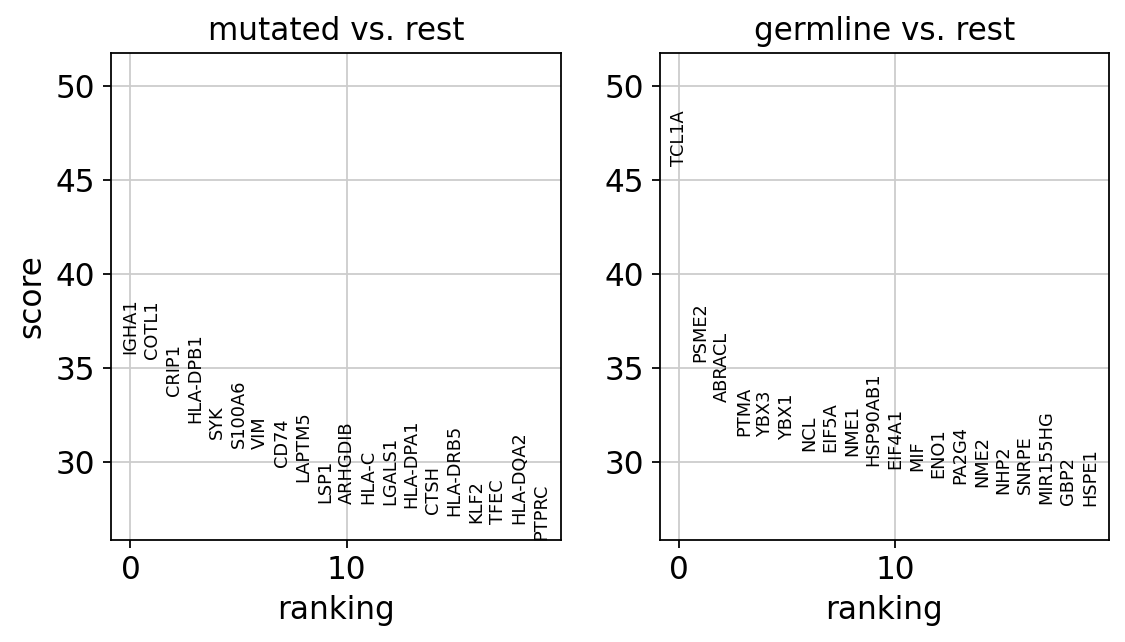

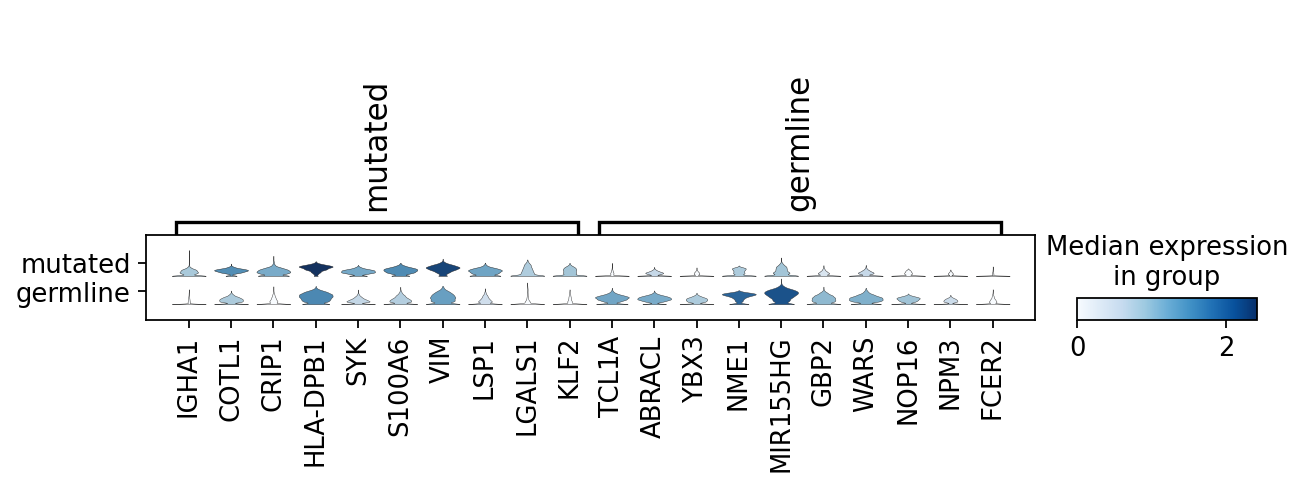

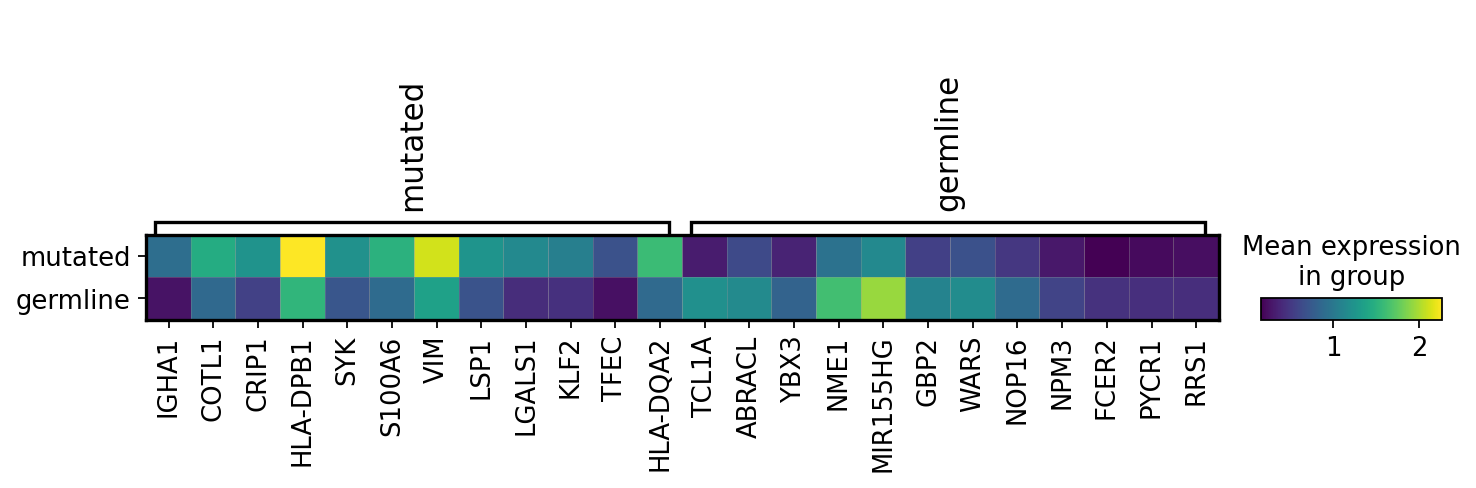

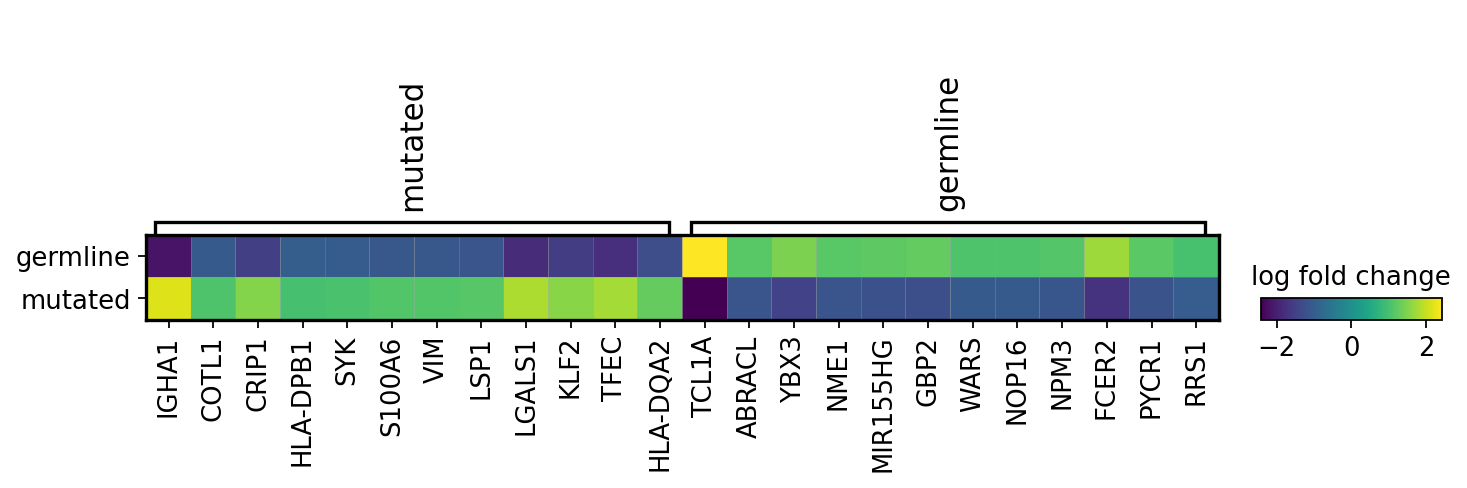

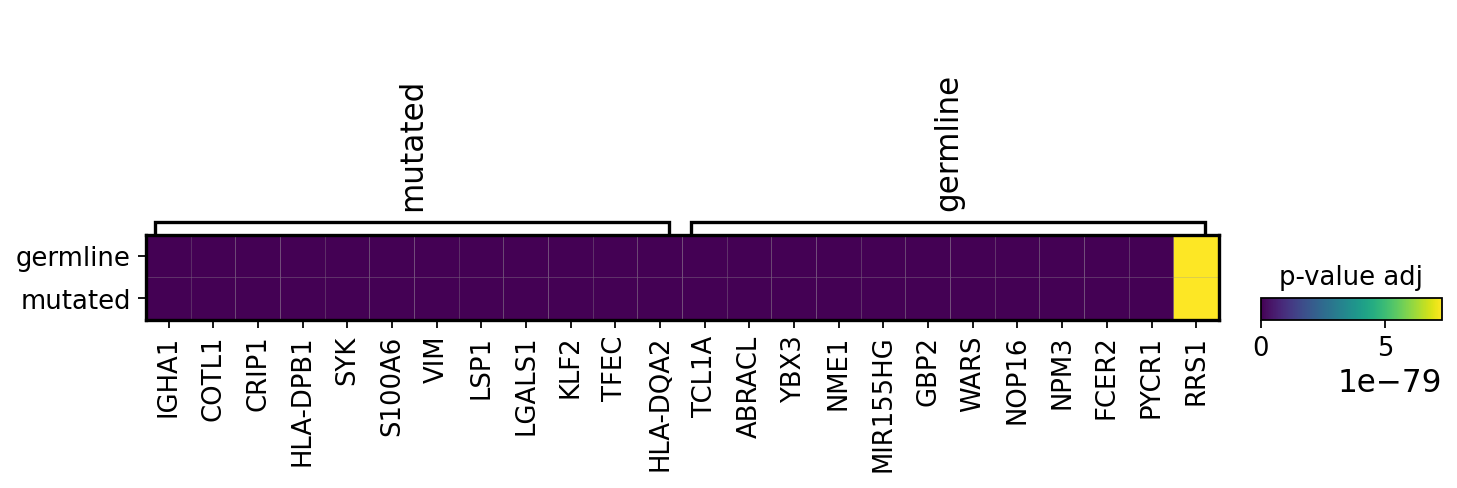

['germline', 'mutated']
Categories (2, object): ['mutated' < 'germline']
germline


/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


mutated


/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


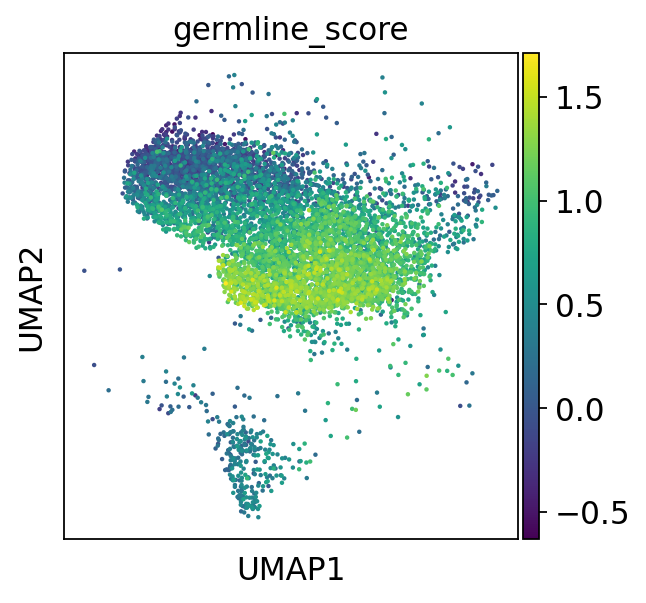

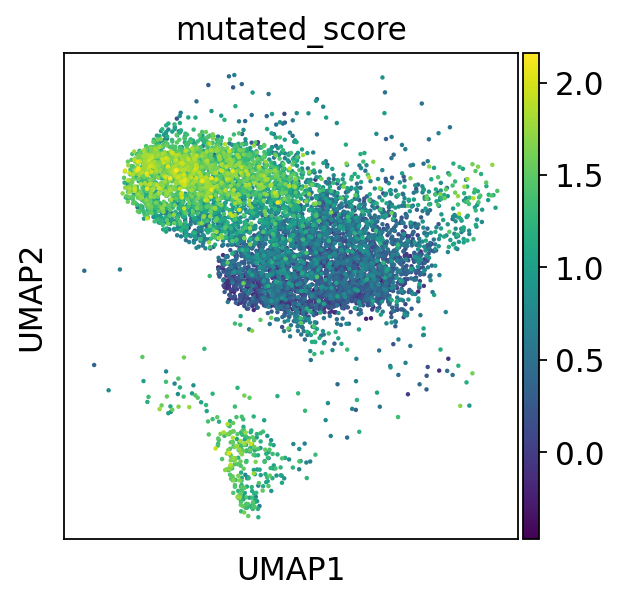

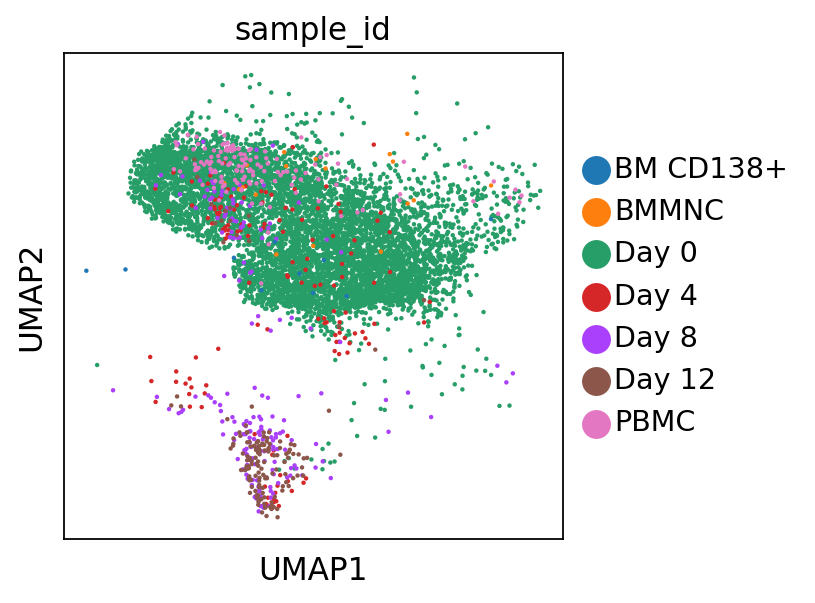

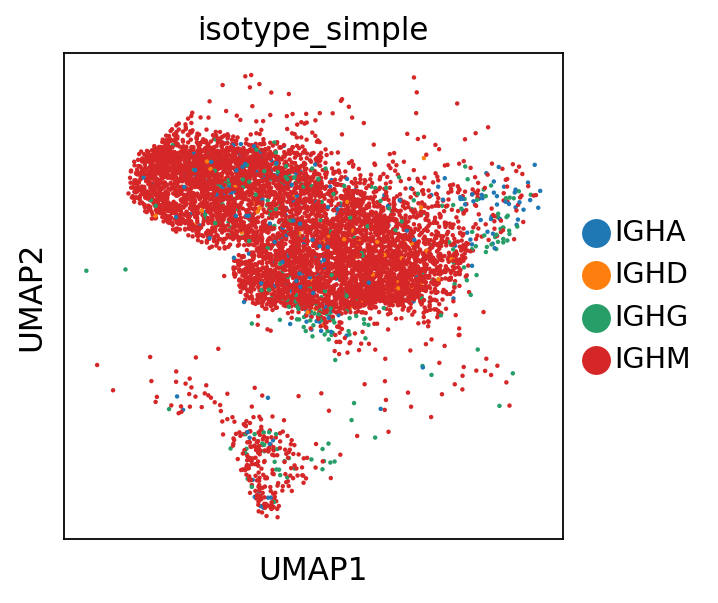

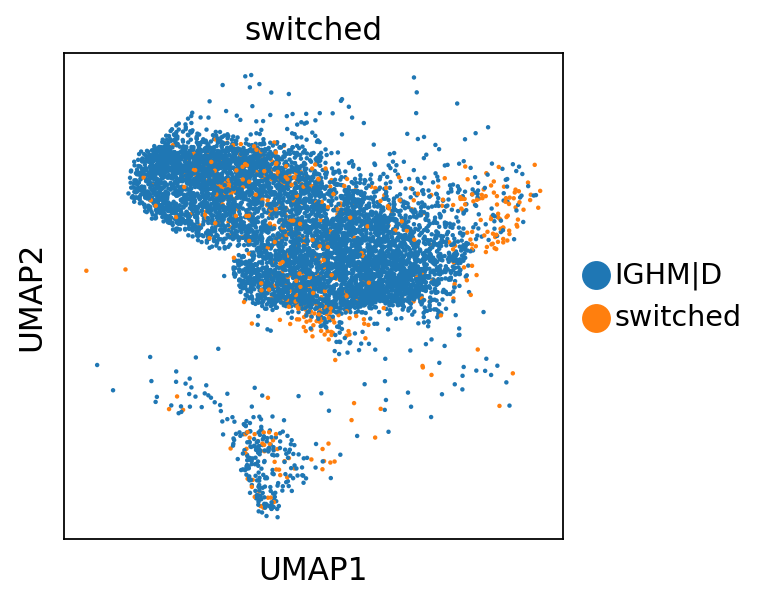

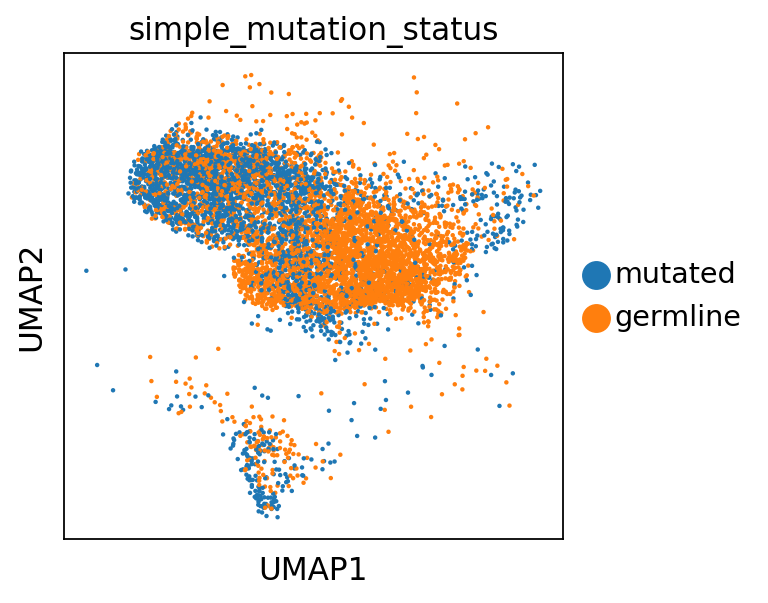

In [6]:
subset_adata, DE = DE_analysis(
    adata, "bcelltype", "B cells", "simple_mutation_status"
)

/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


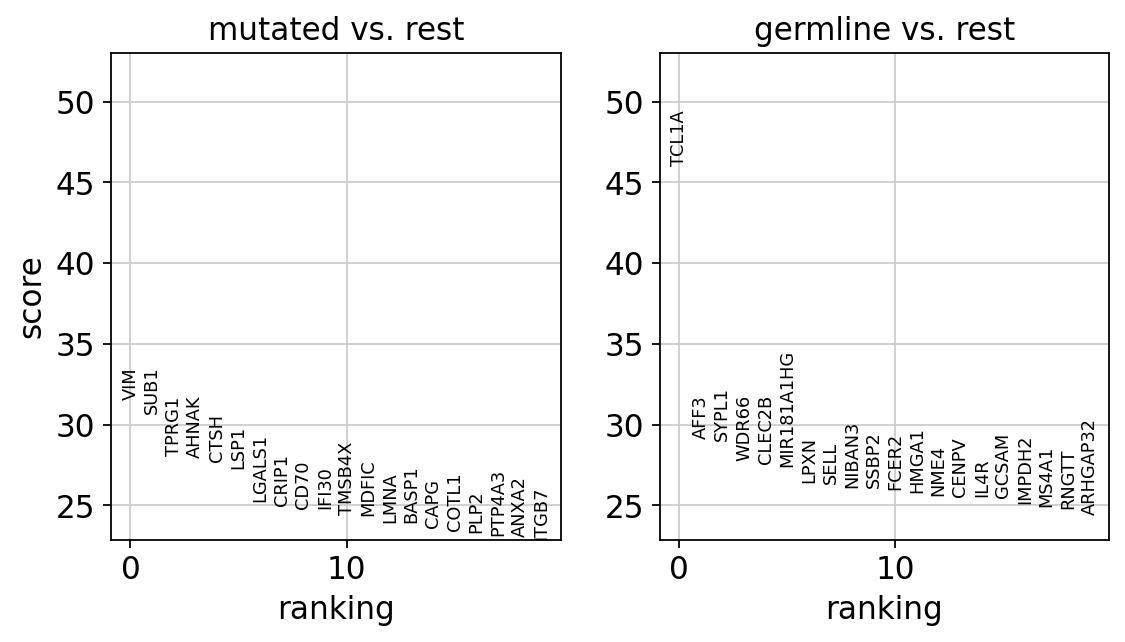

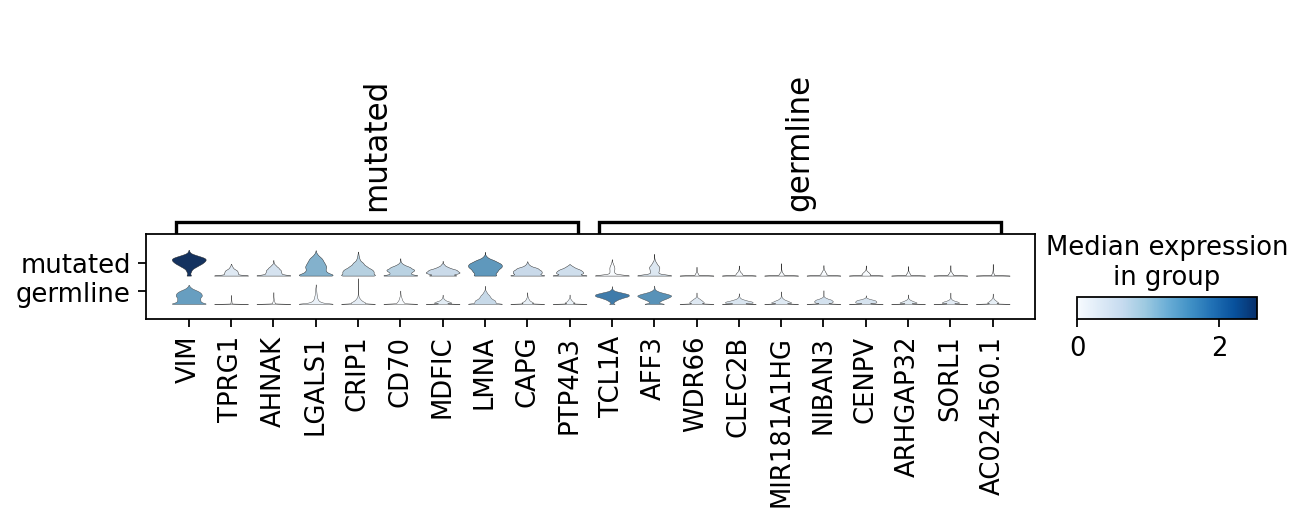

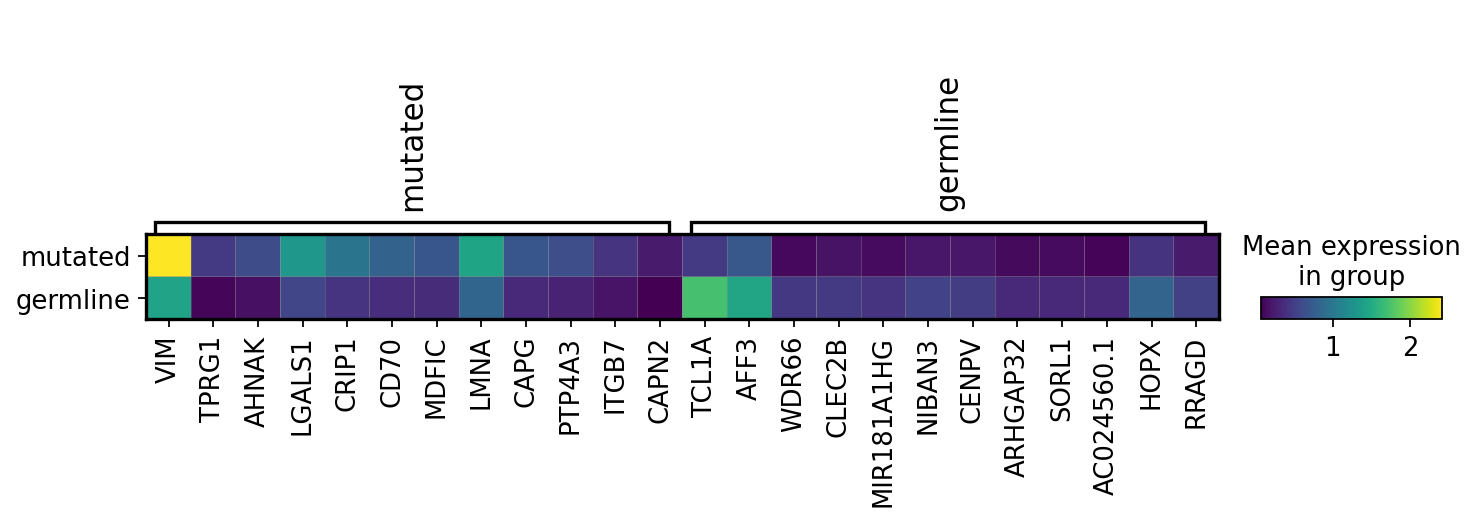

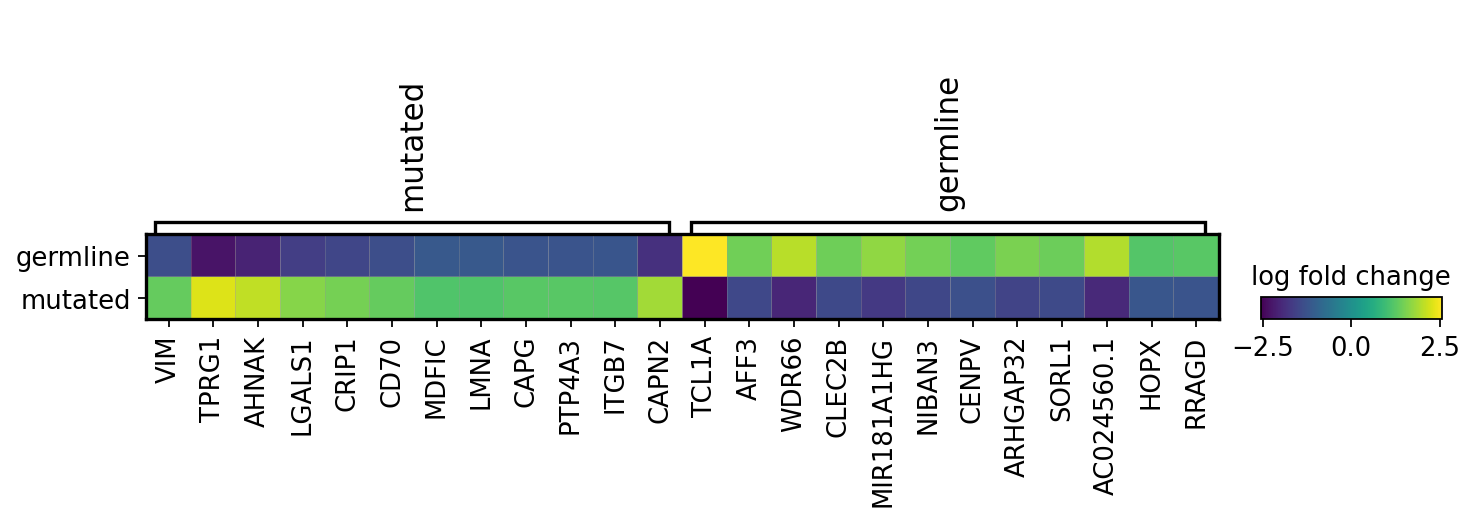

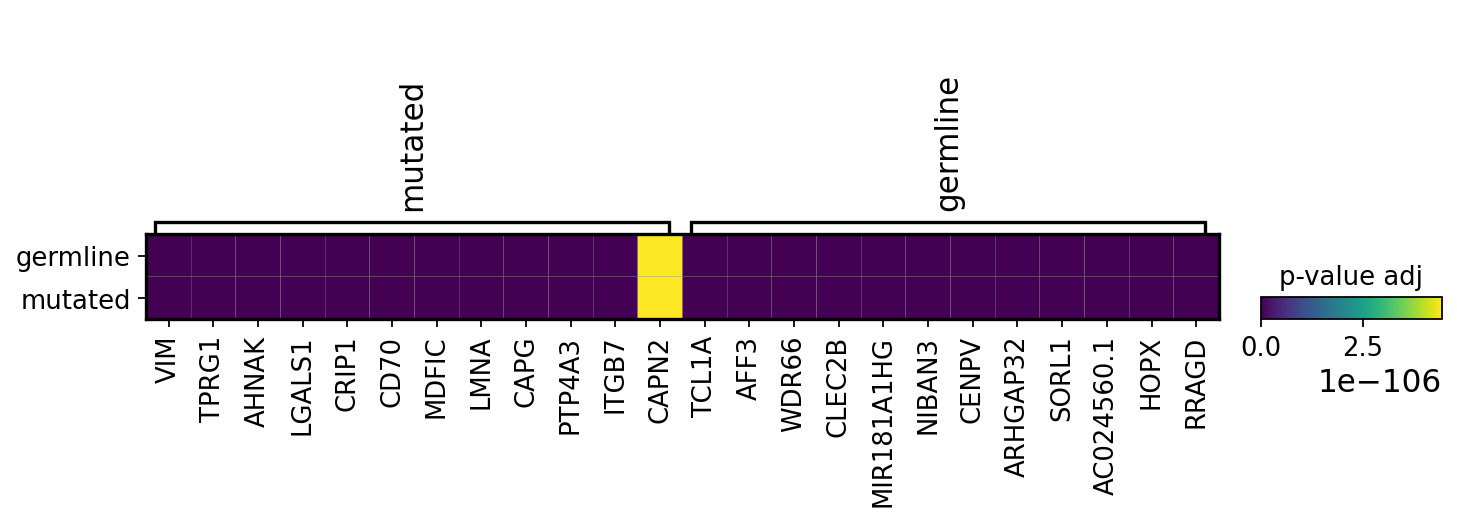

['mutated', 'germline']
Categories (2, object): ['mutated' < 'germline']
mutated


/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


germline


/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


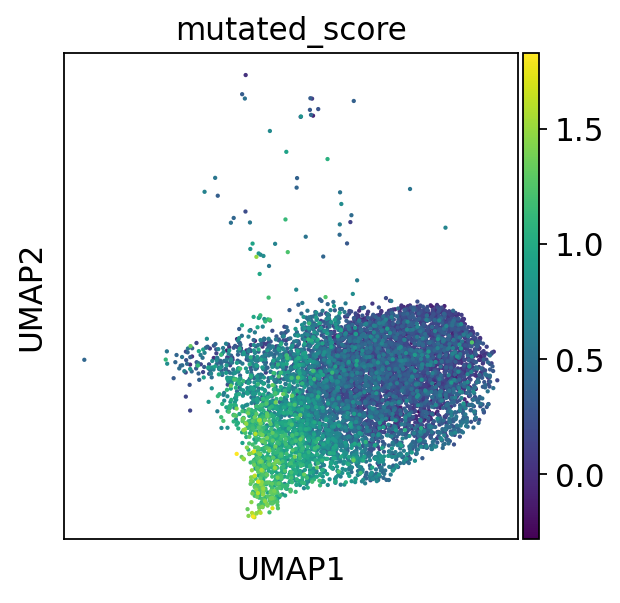

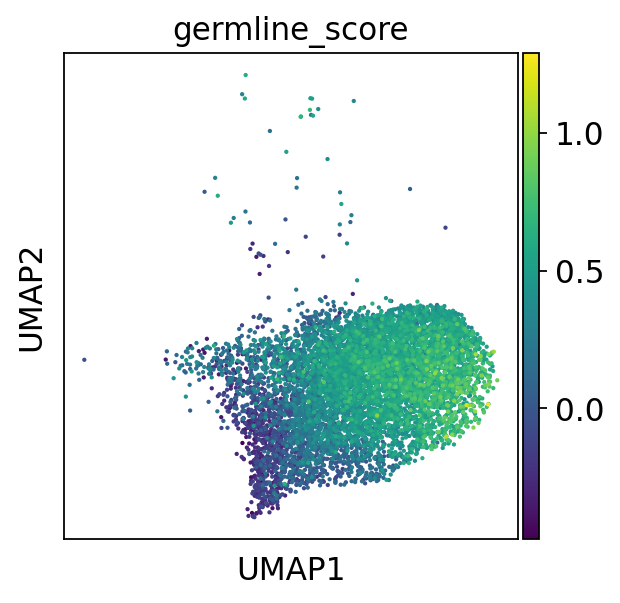

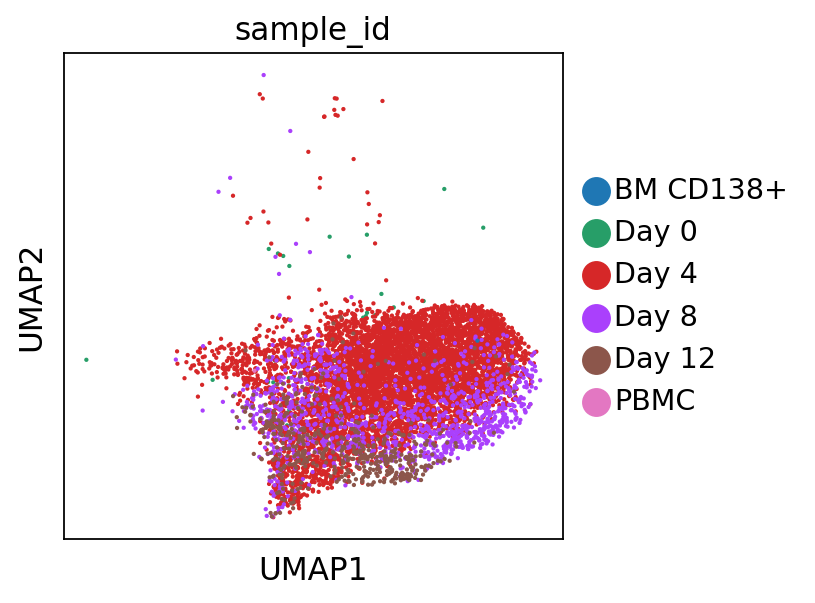

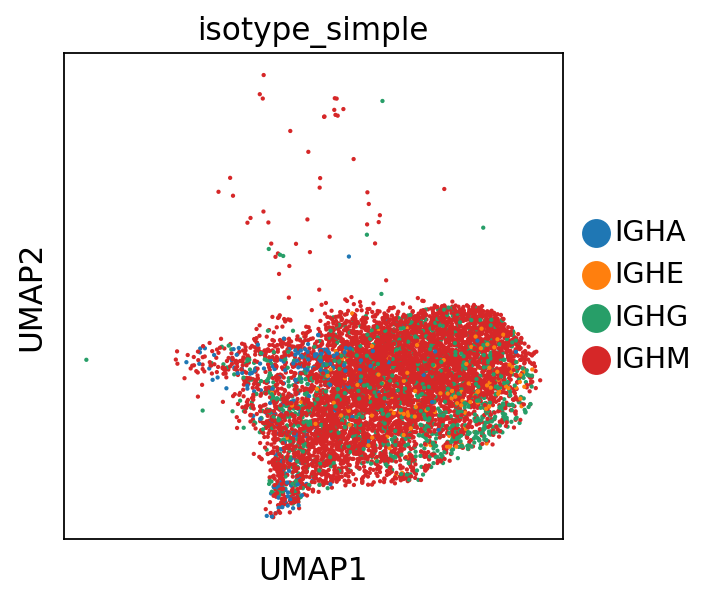

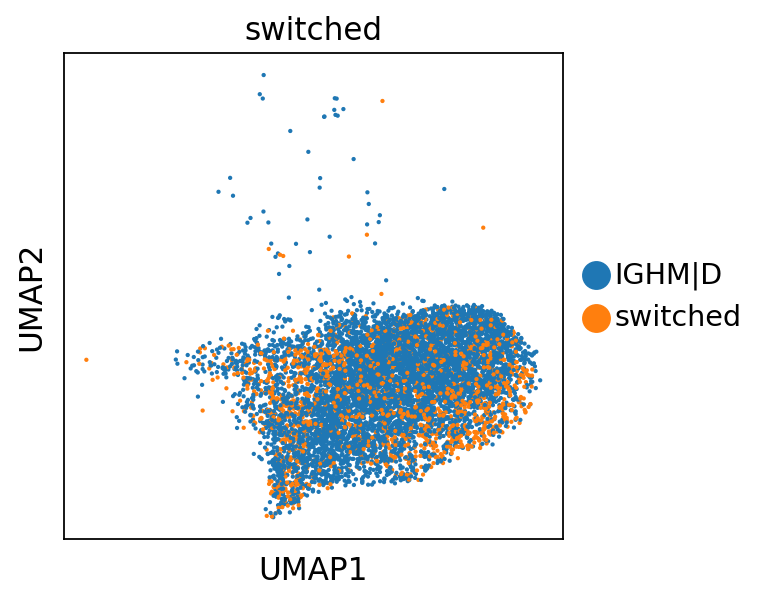

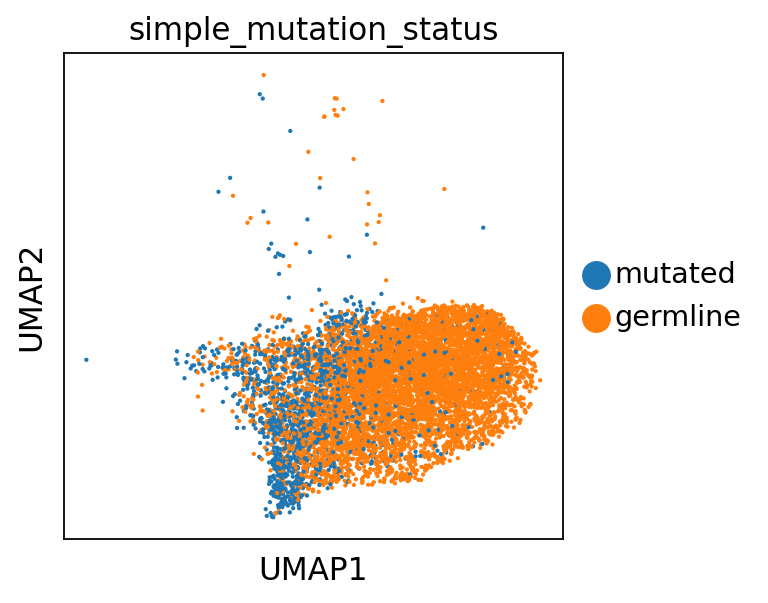

In [7]:
subset_adata, DE = DE_analysis(
    adata, "bcelltype", "Prolif. GC B cells", "simple_mutation_status", min_logfoldchange=1.1
)

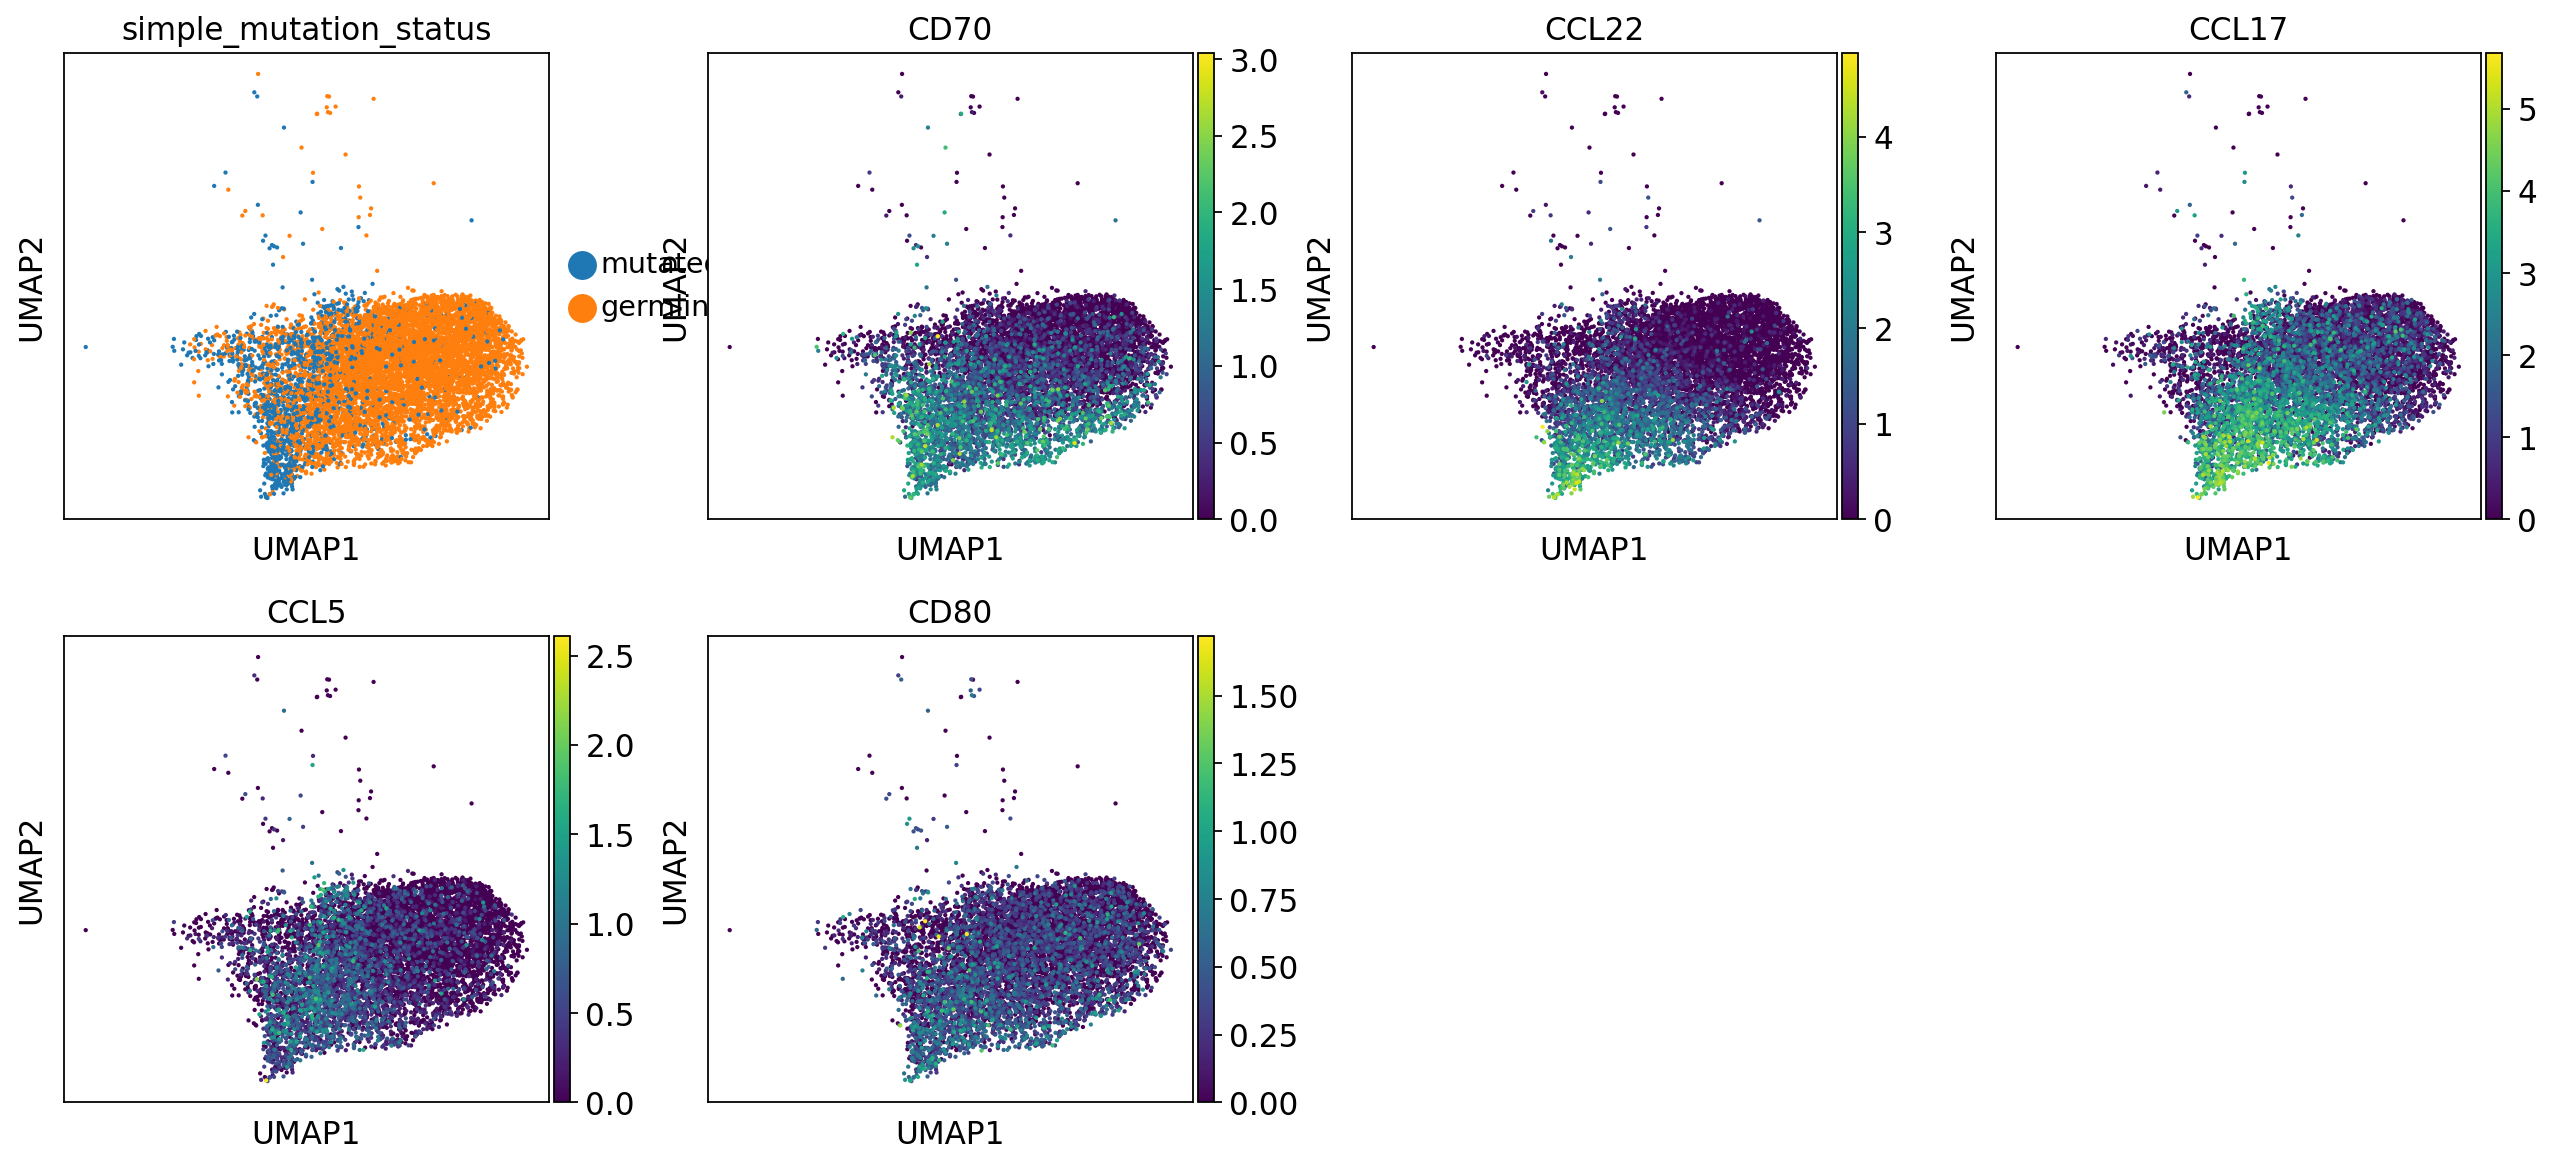

In [8]:
sc.pl.umap(subset_adata, color = ['simple_mutation_status', 'CD70', "CCL22", "CCL17", "CCL5", "CD80", ])

/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


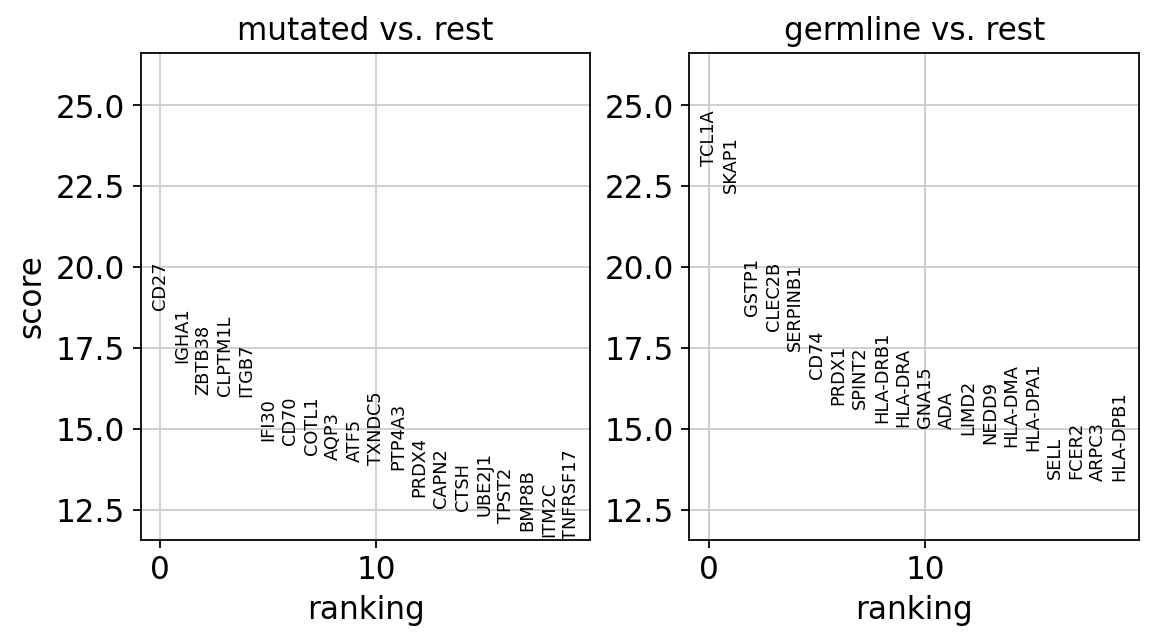

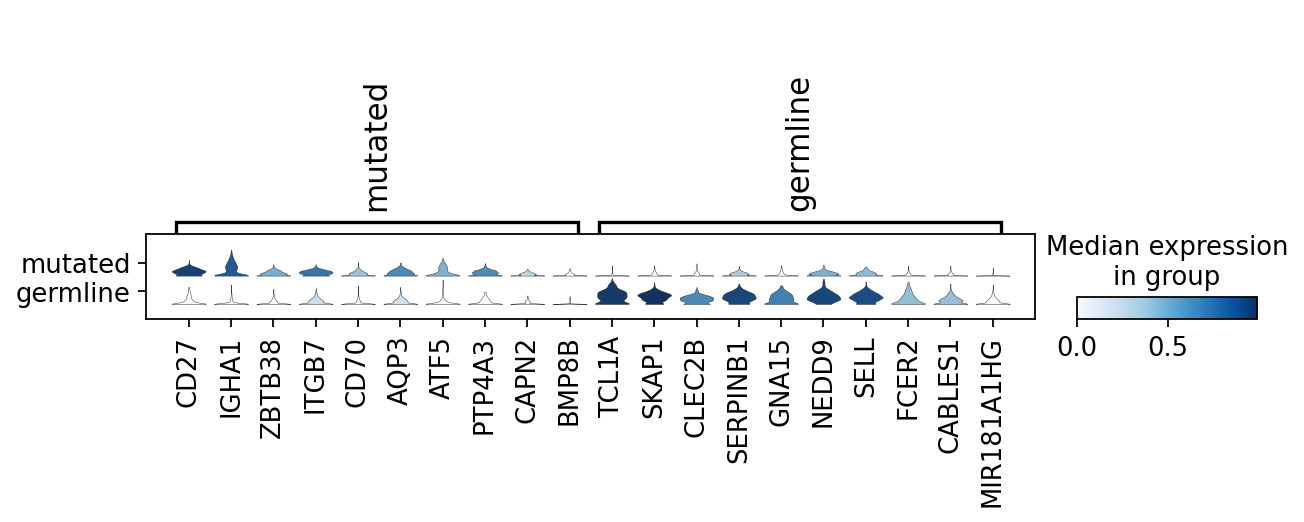

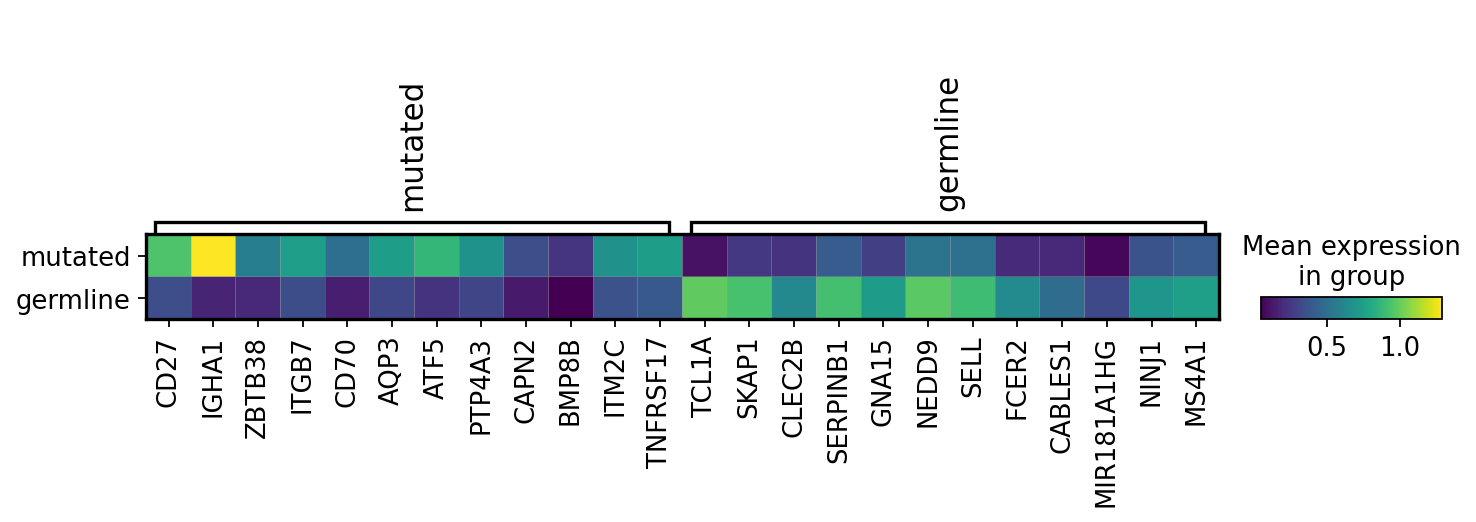

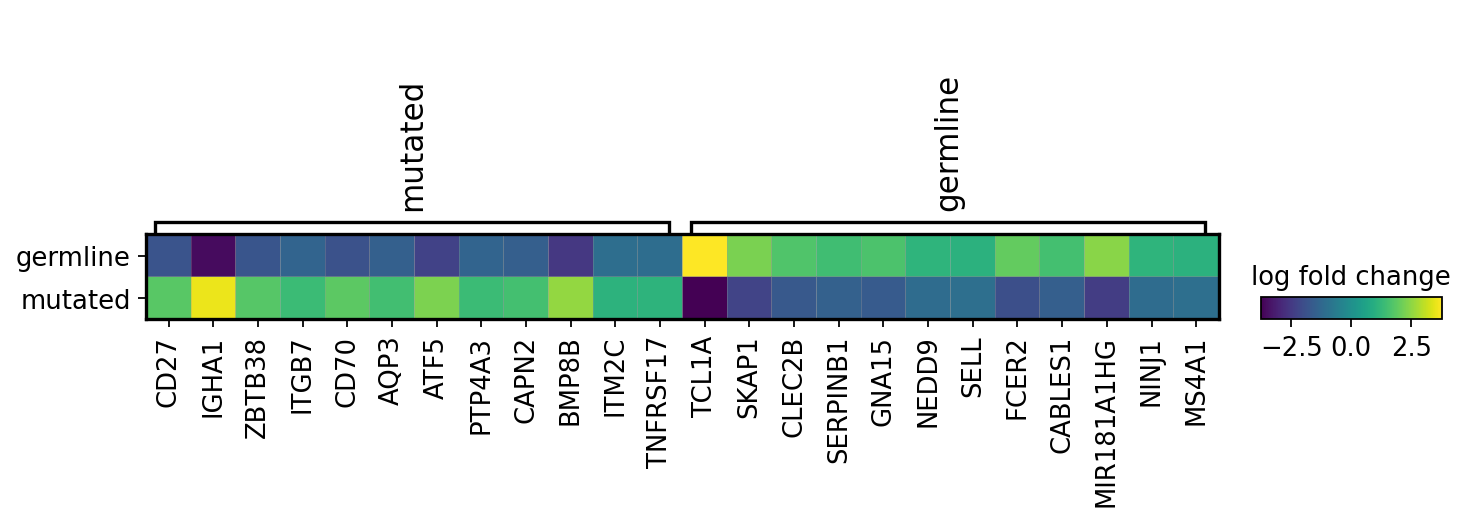

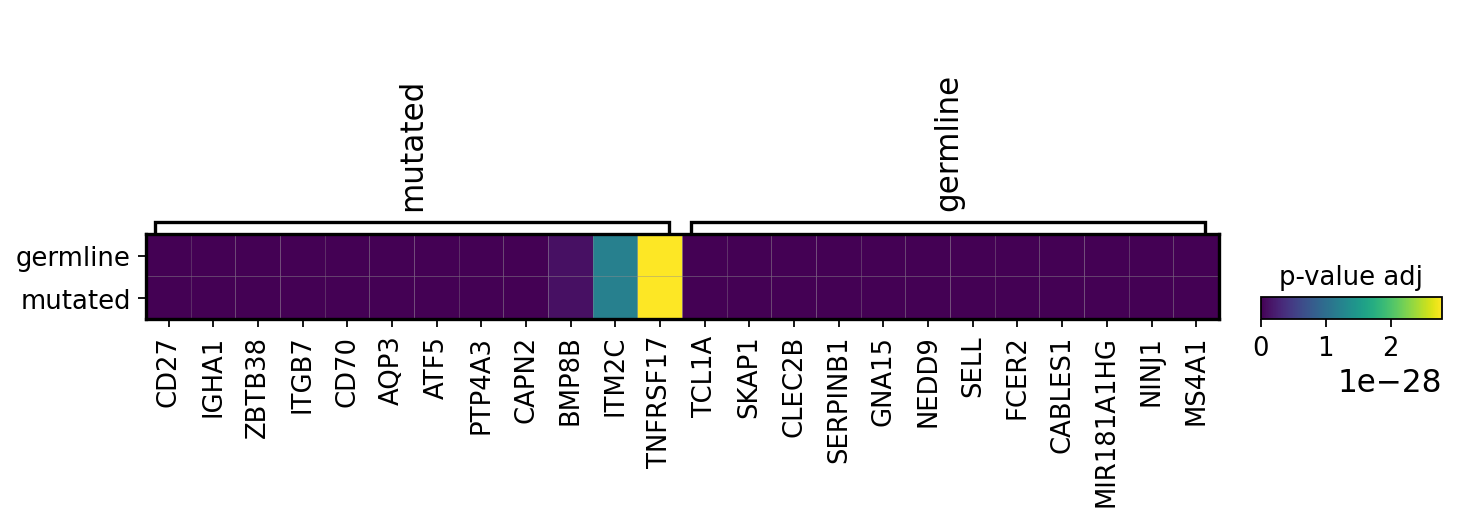

['mutated', 'germline']
Categories (2, object): ['mutated' < 'germline']
mutated
germline


/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


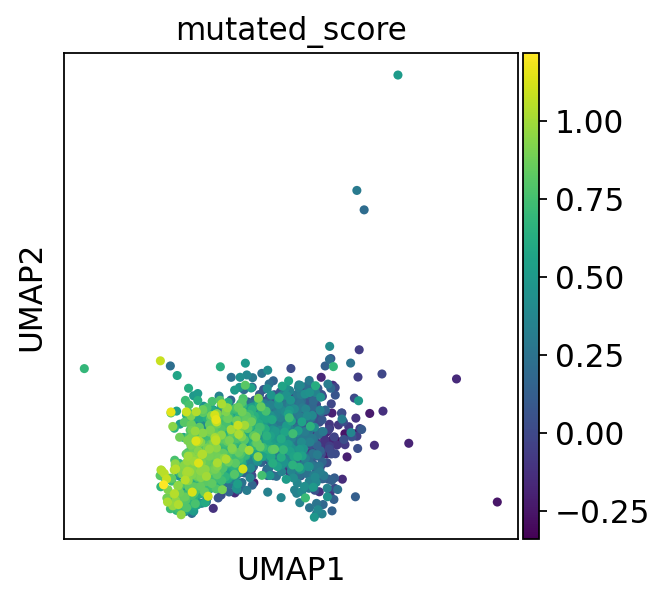

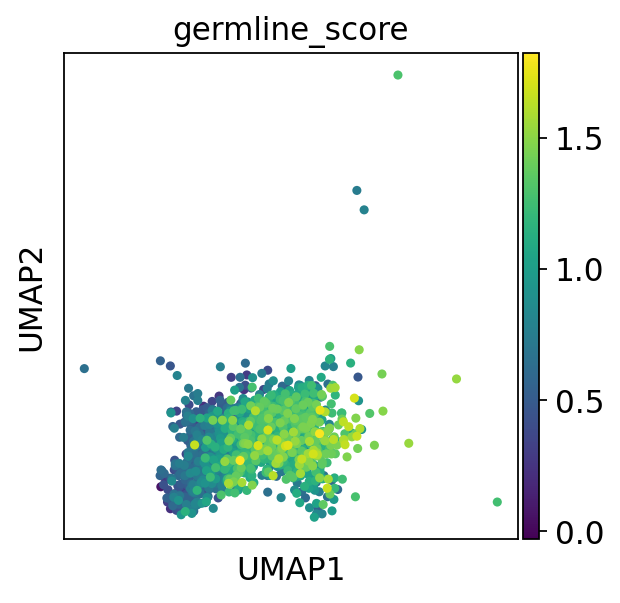

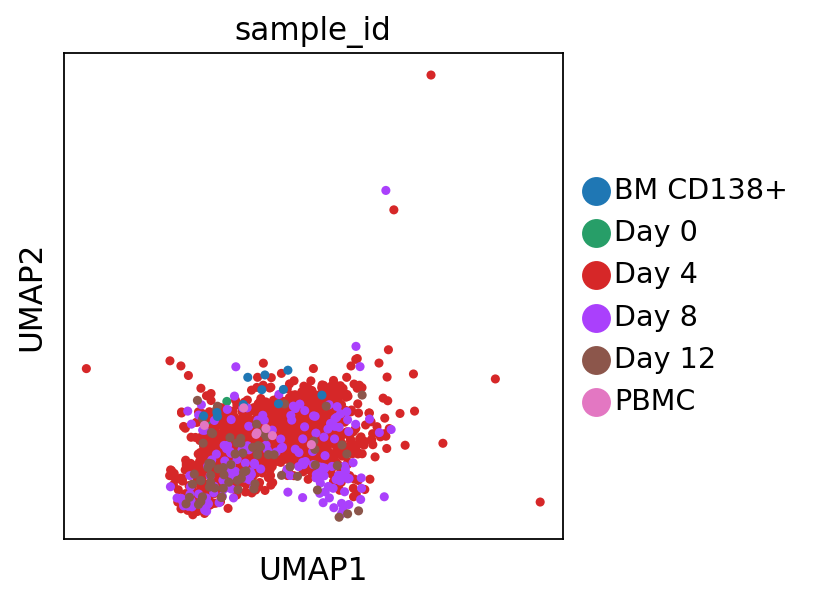

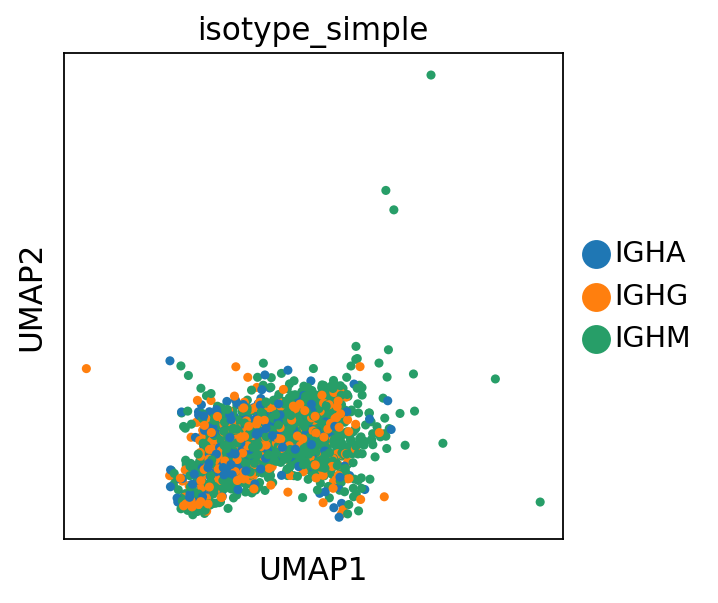

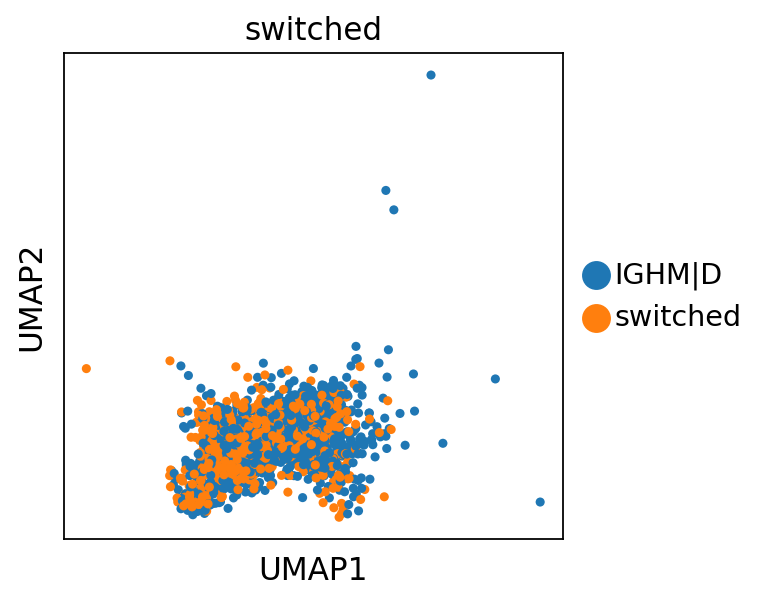

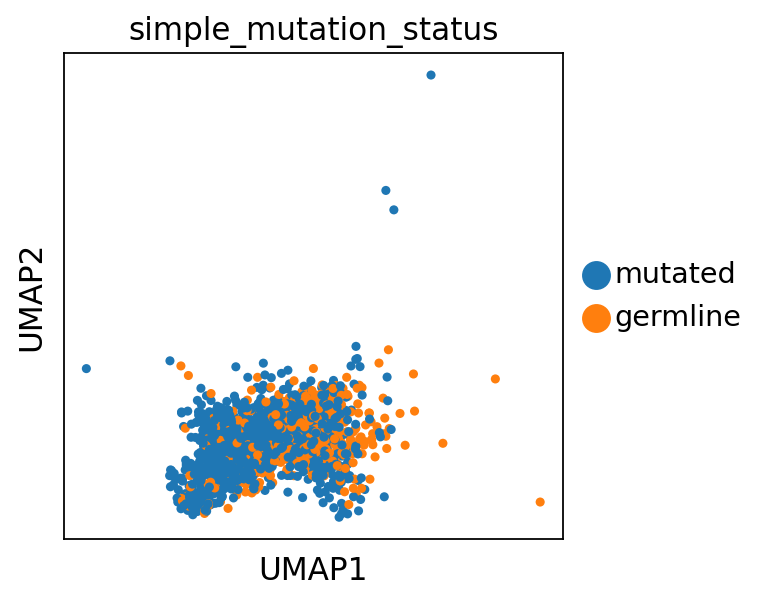

In [10]:
subset_adata, DE = DE_analysis(
    adata, "bcelltype", "Plasmablasts", "simple_mutation_status"
)

/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


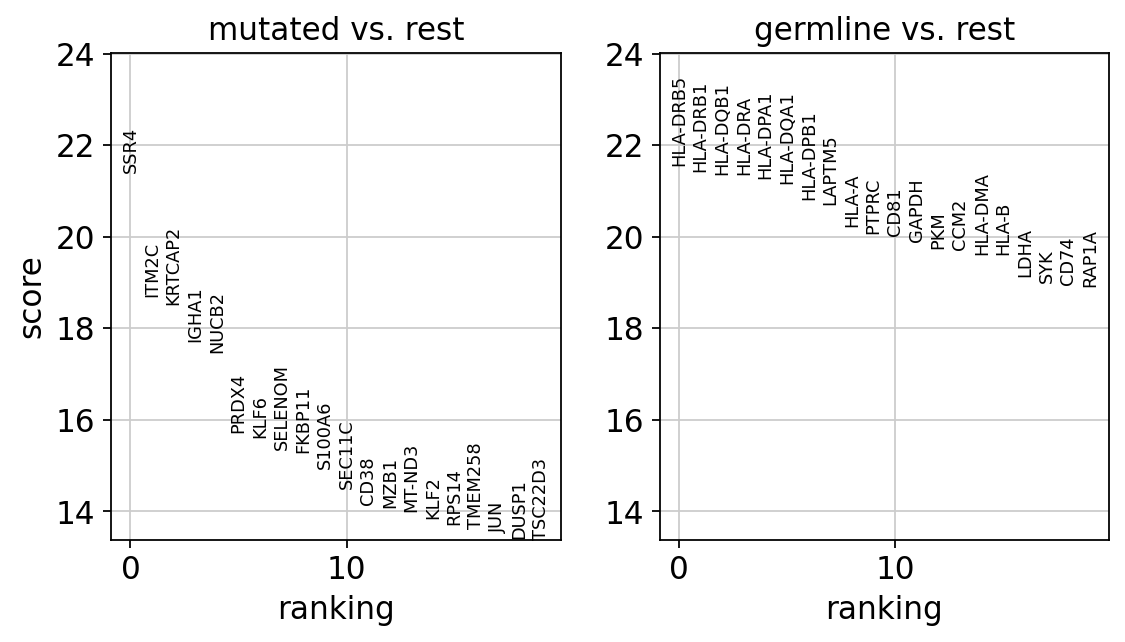

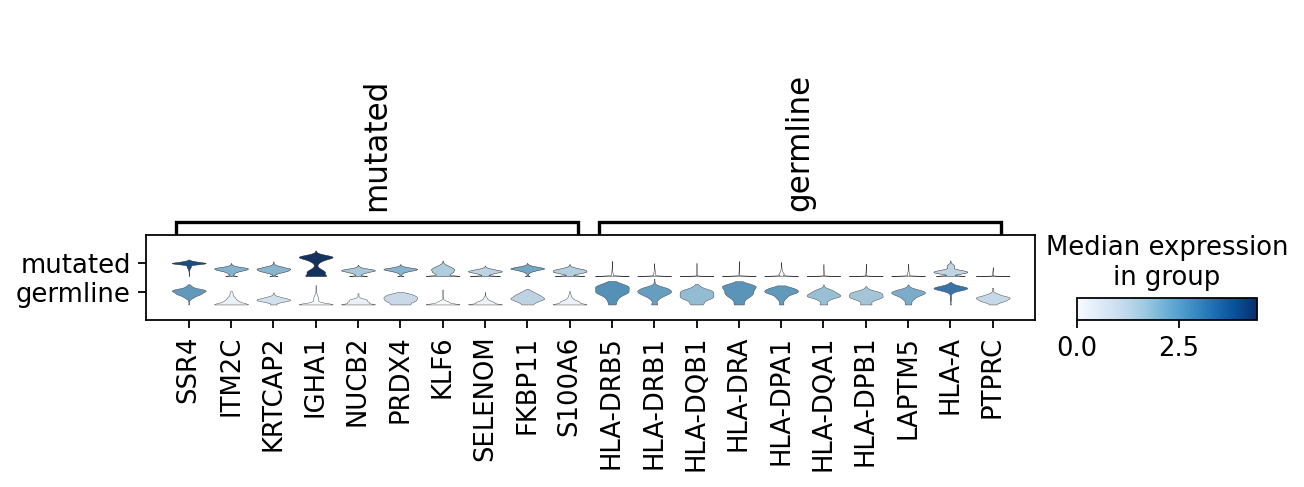

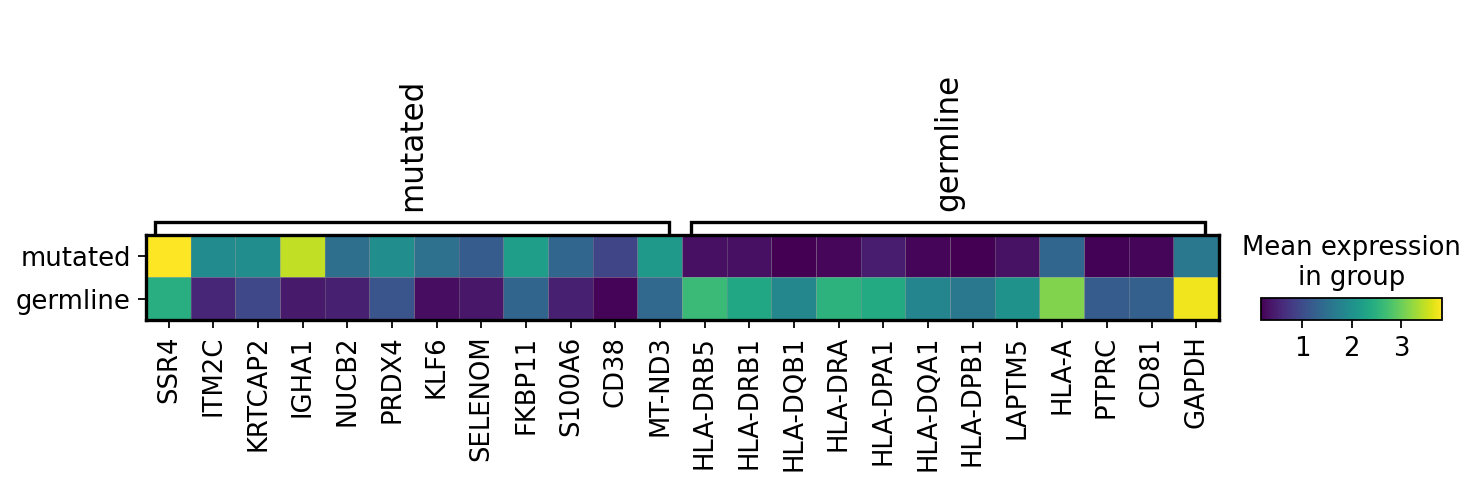

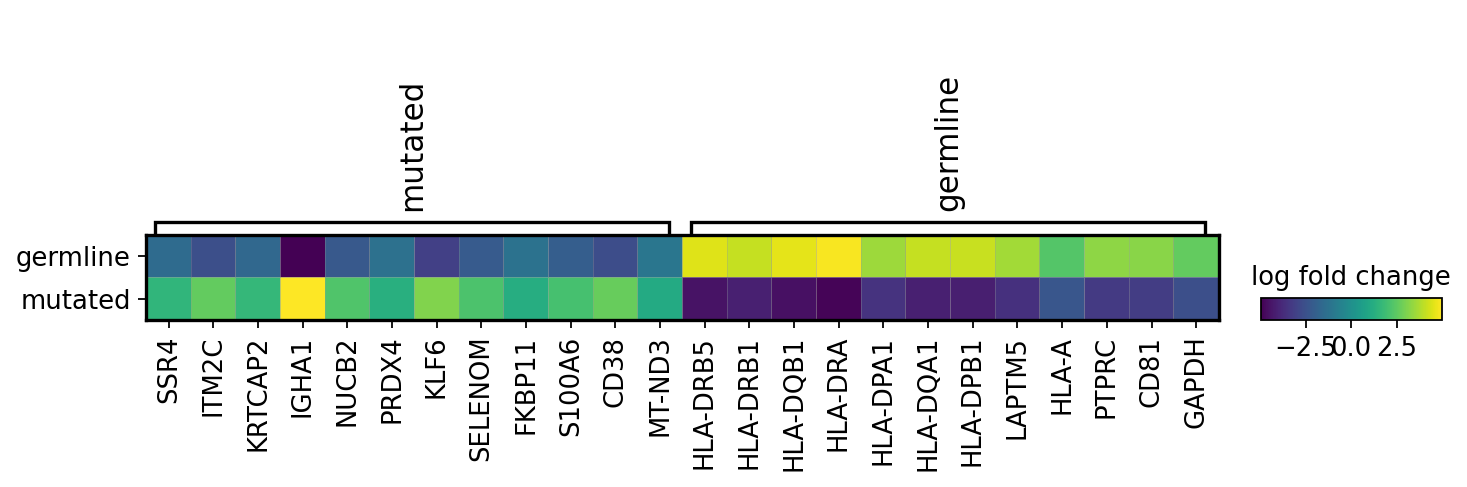

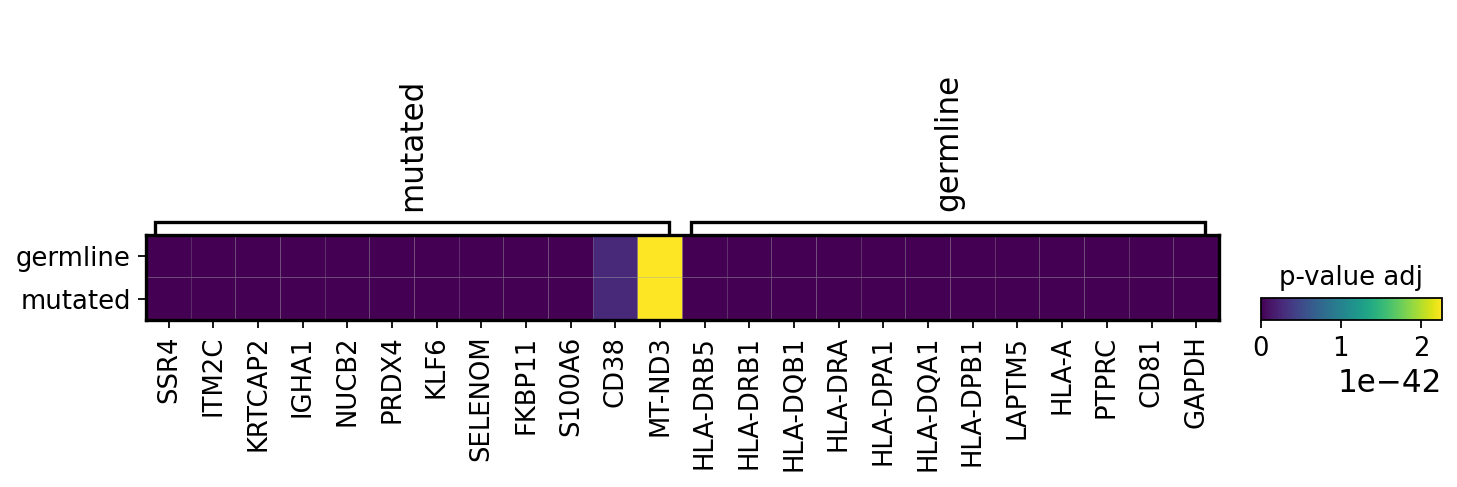

['mutated', 'germline']
Categories (2, object): ['mutated' < 'germline']
mutated
germline


/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


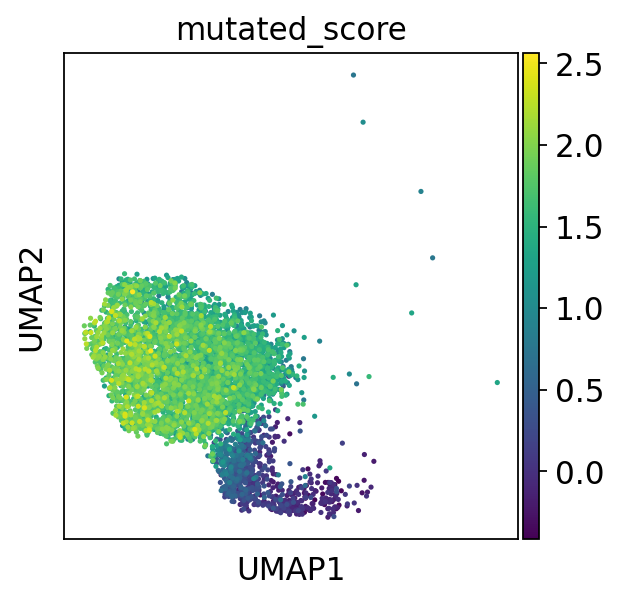

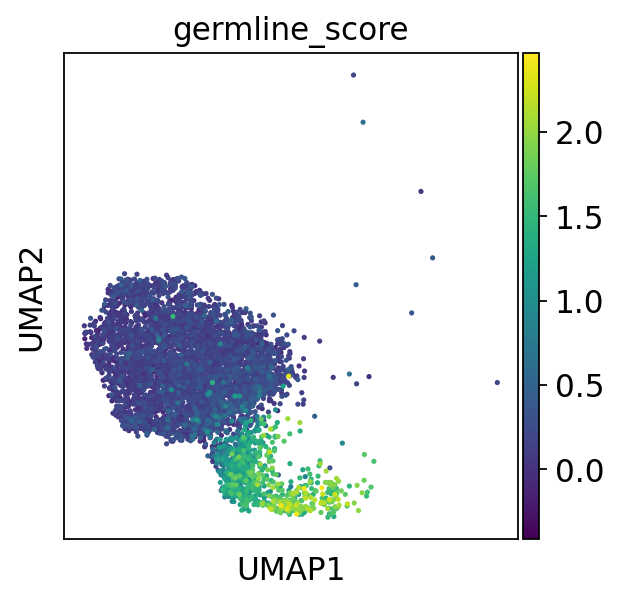

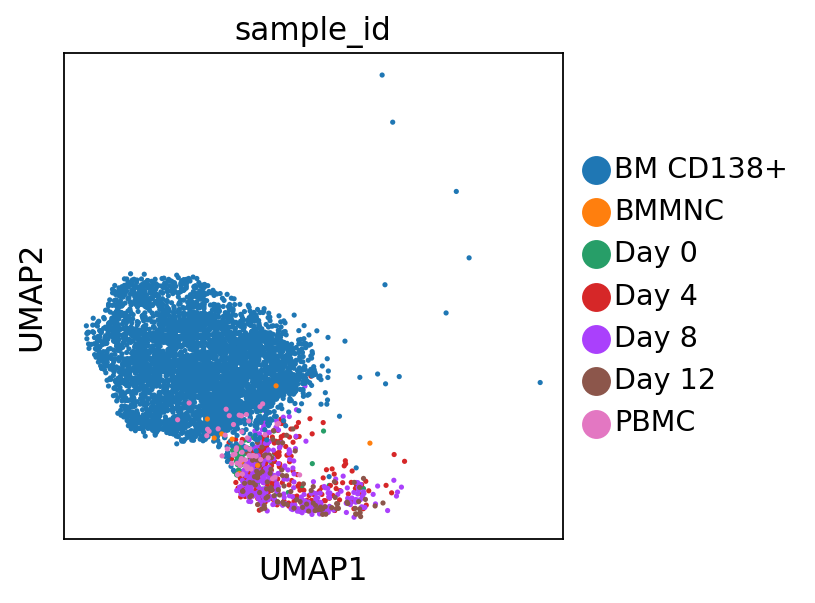

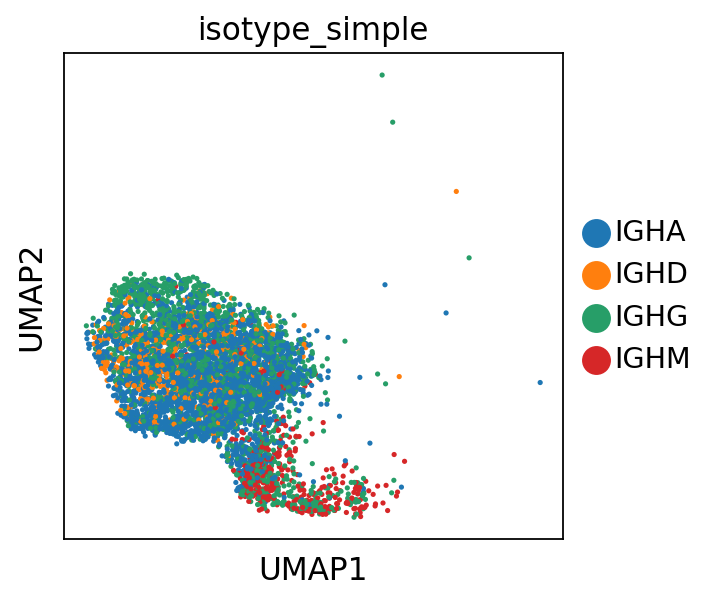

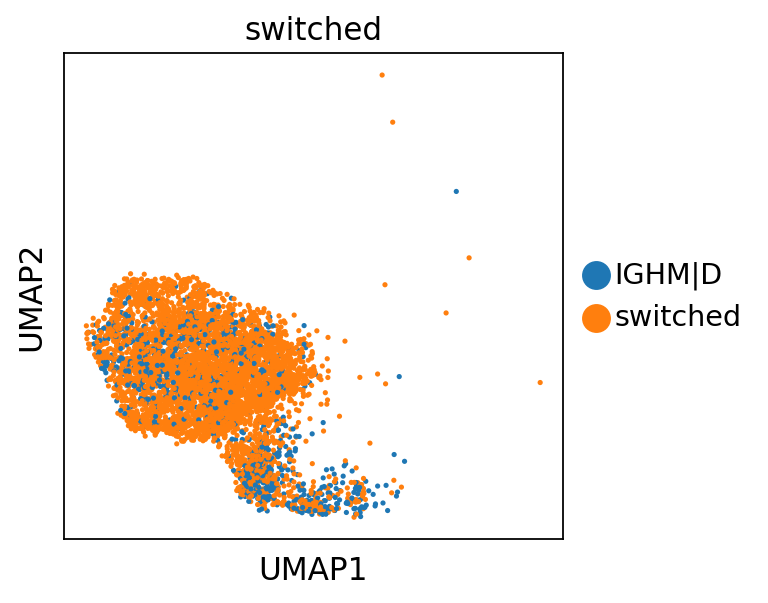

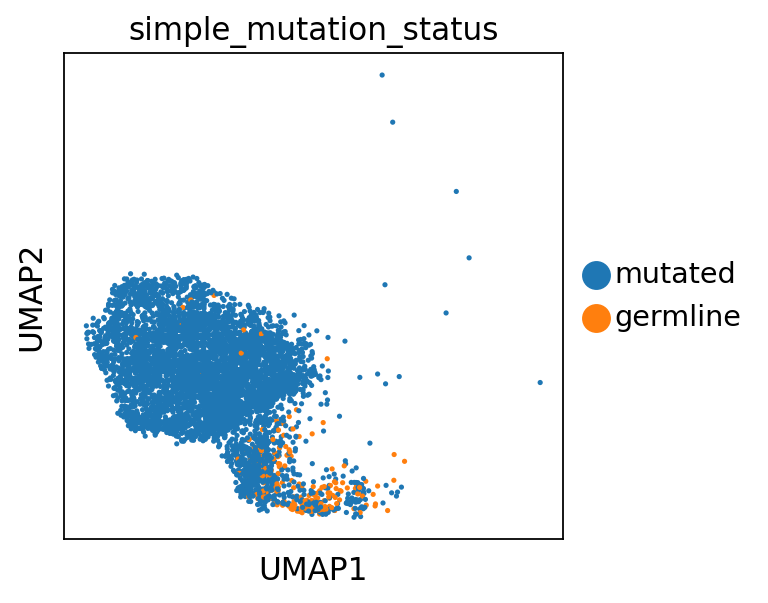

In [11]:
subset_adata, DE = DE_analysis(
    adata, "bcelltype", "Plasma cells", "simple_mutation_status"
)

/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


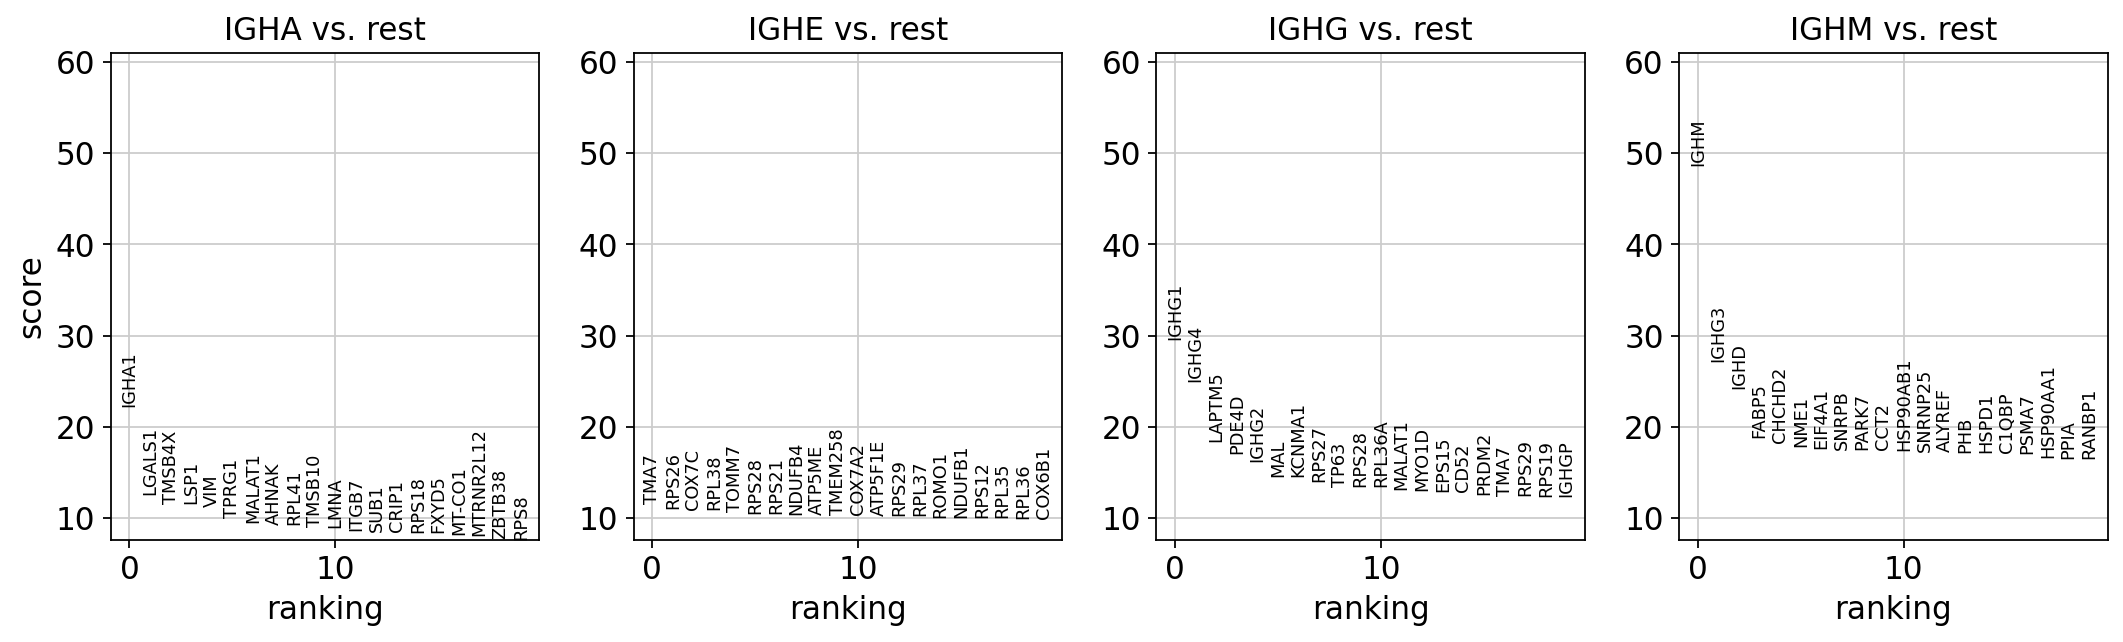

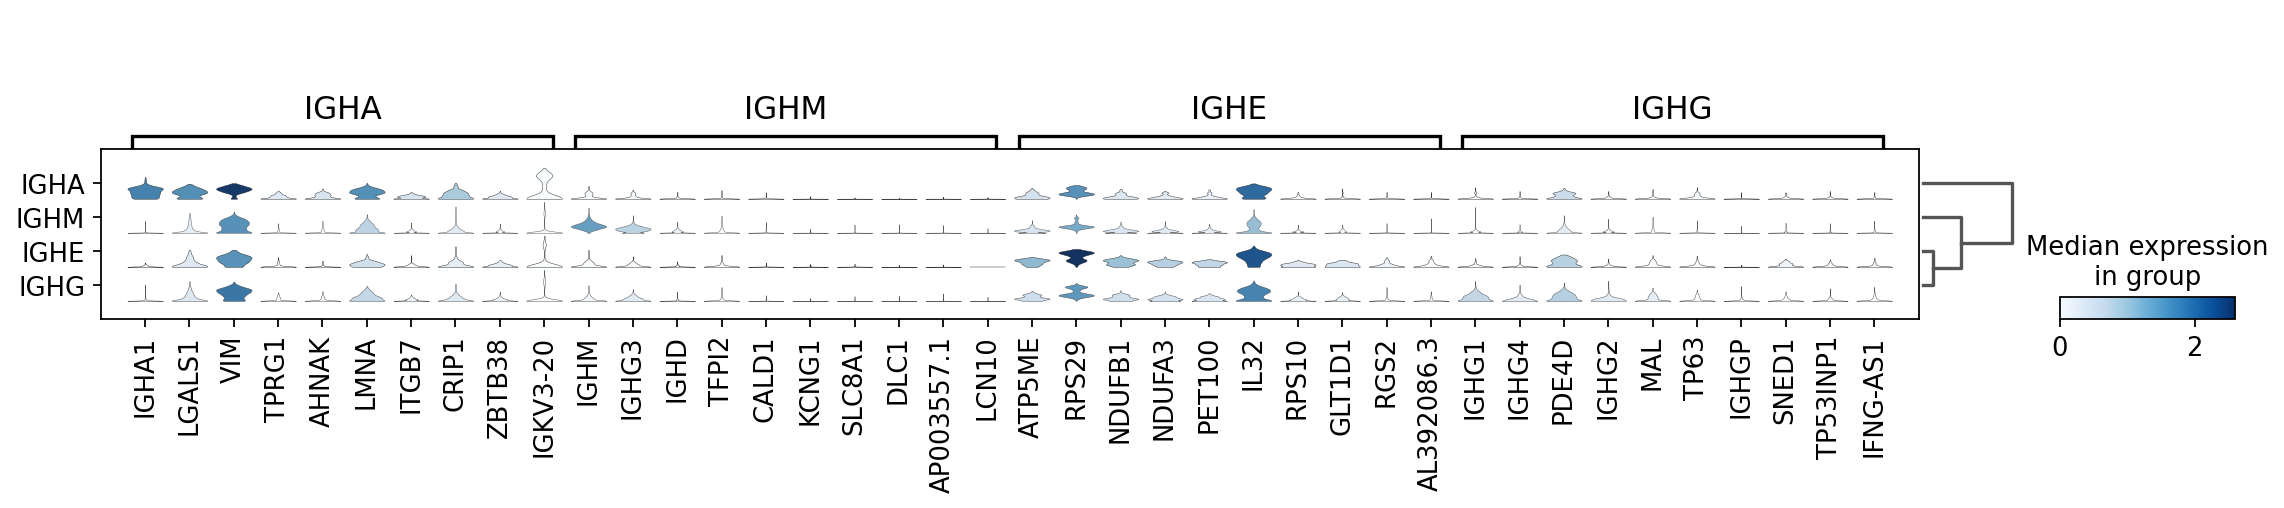

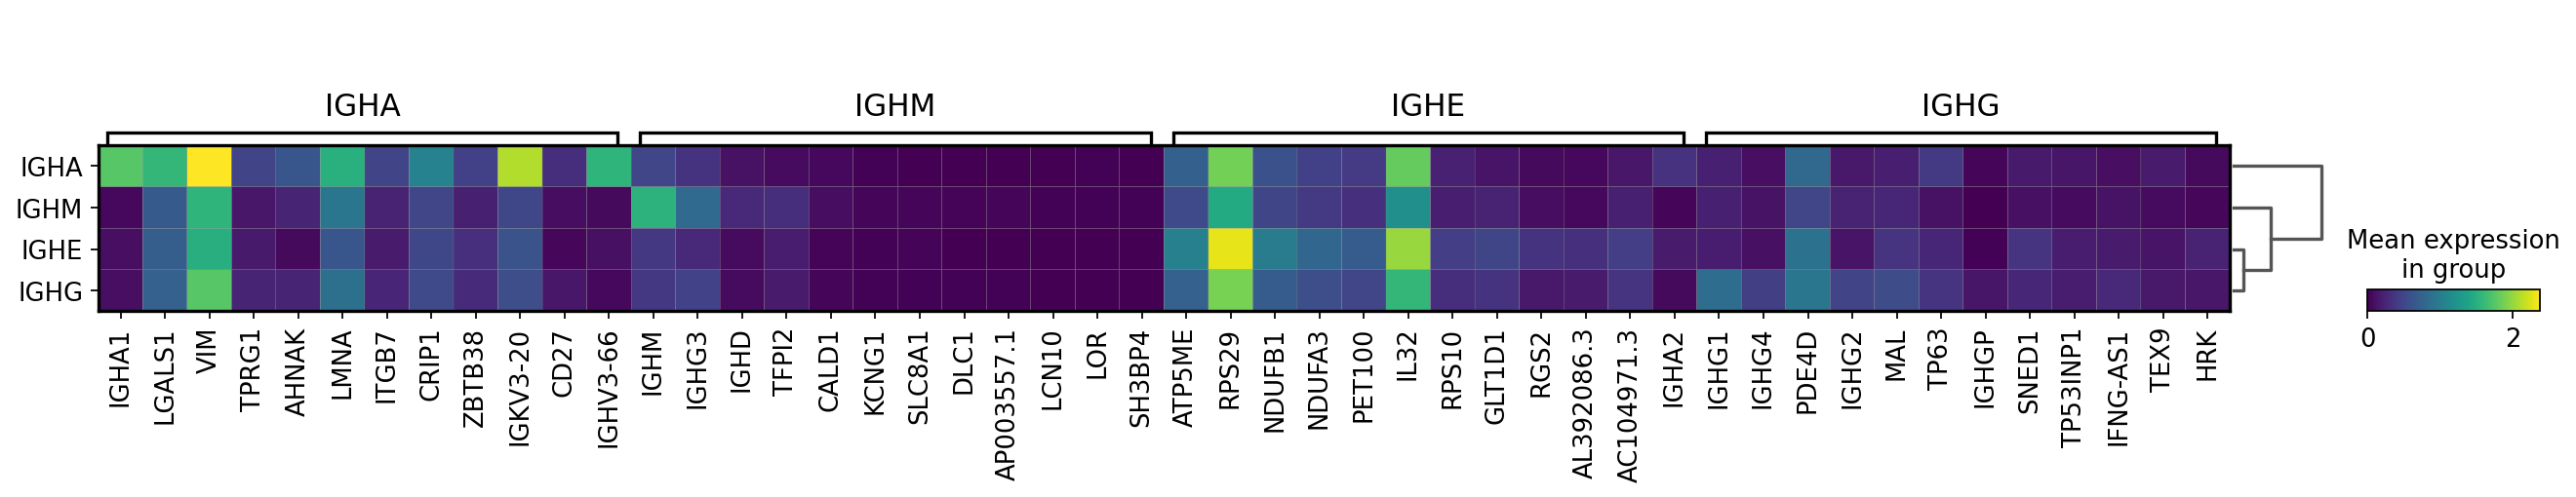

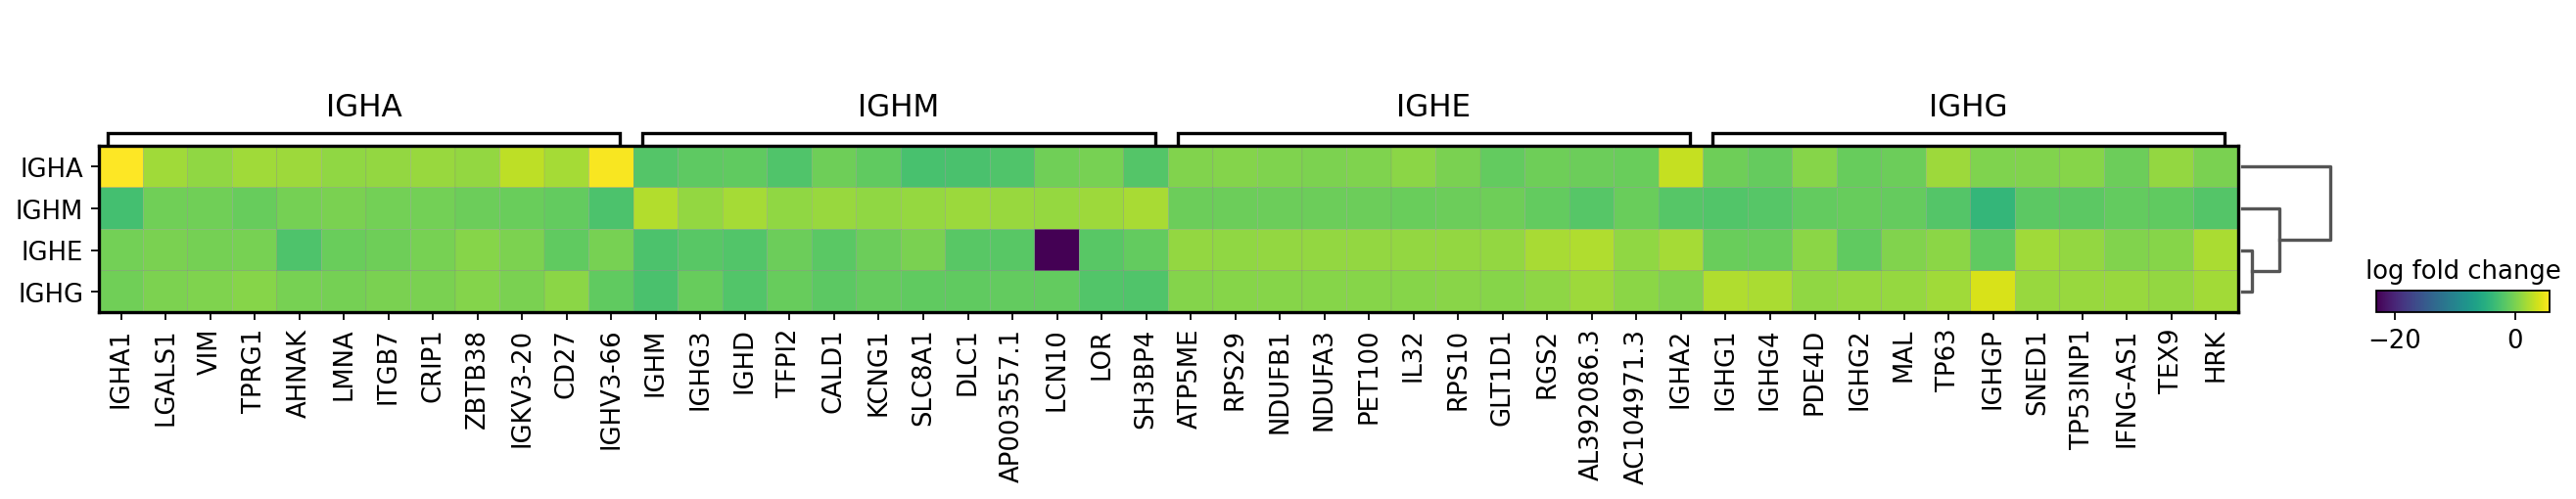

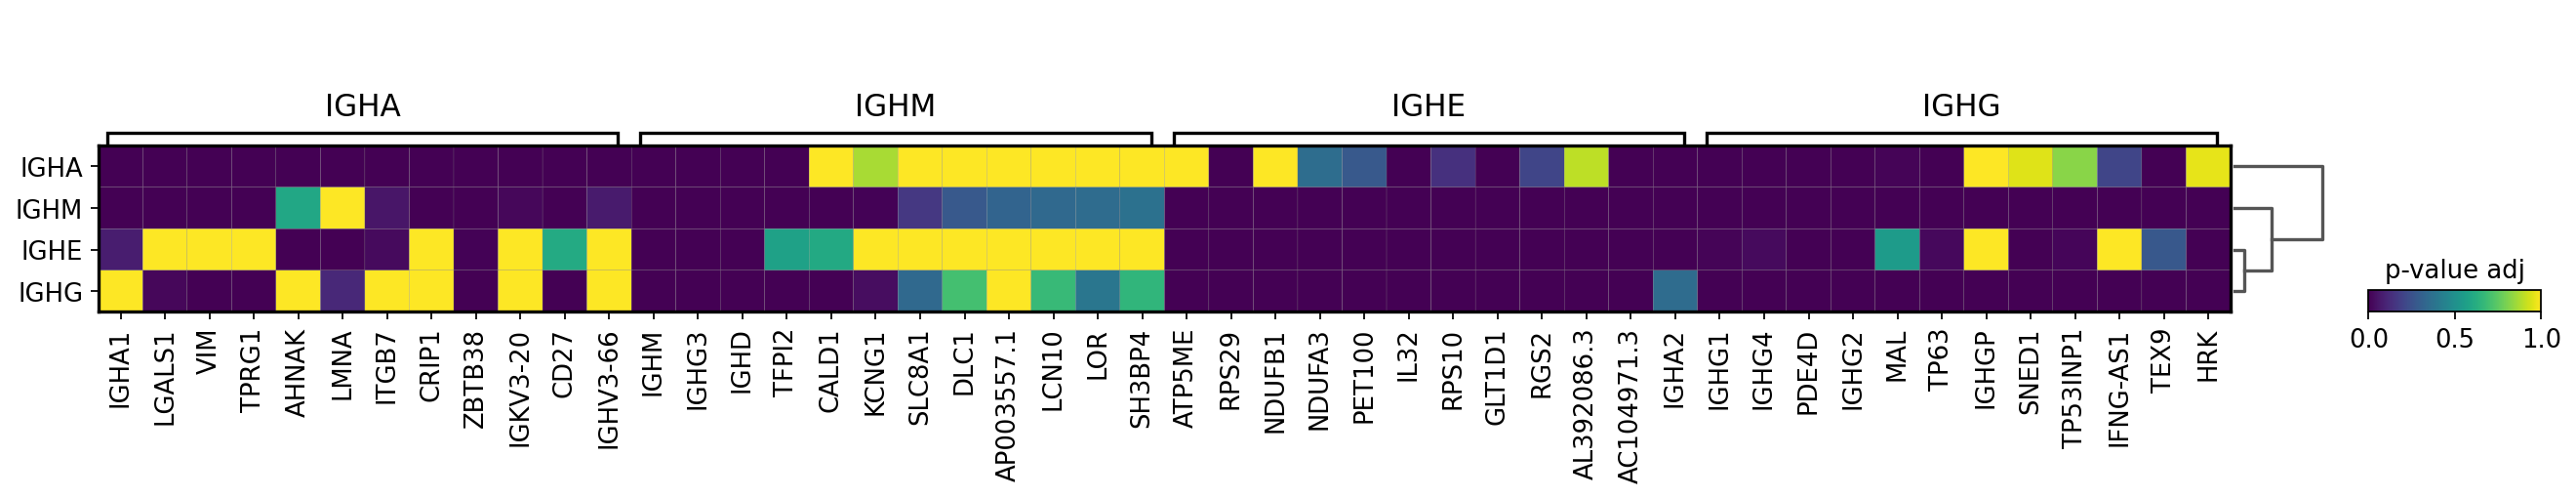

['IGHG', 'IGHM', 'IGHA', 'IGHE']
Categories (4, object): ['IGHA', 'IGHE', 'IGHG', 'IGHM']
IGHG


/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


IGHM


/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


IGHA


/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


IGHE


/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


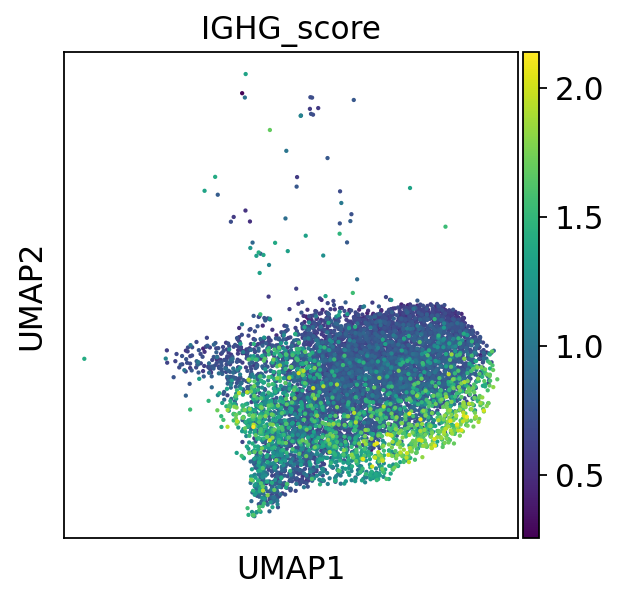

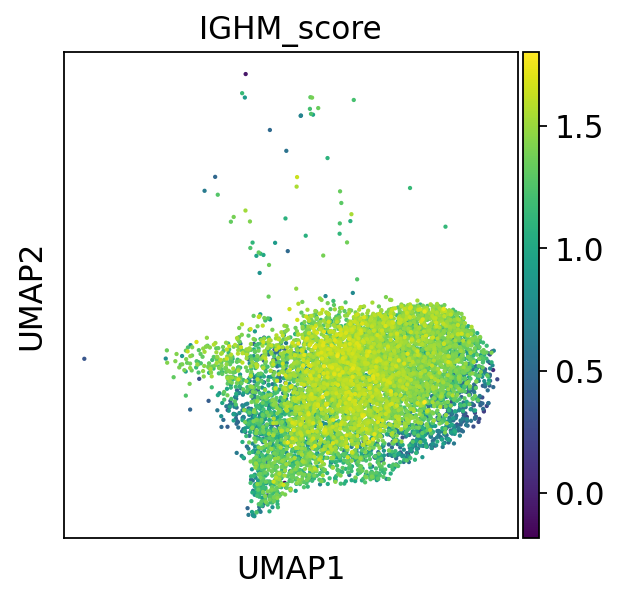

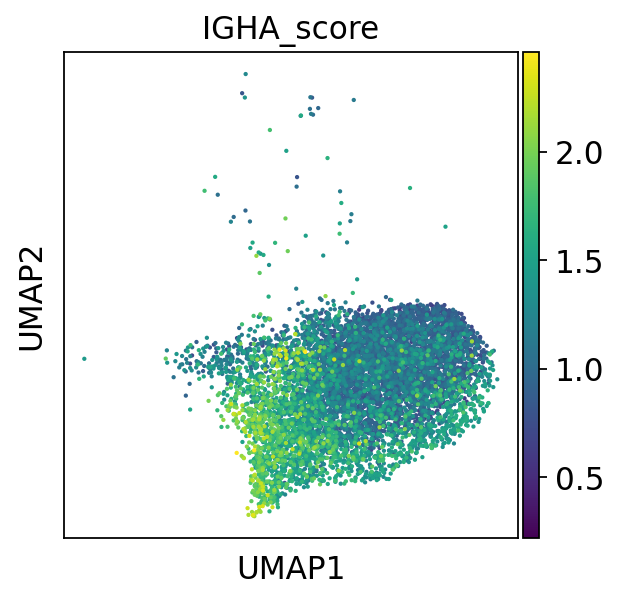

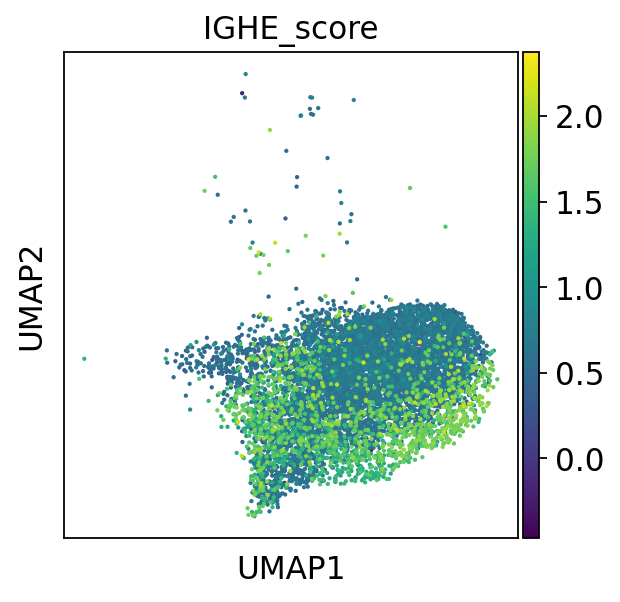

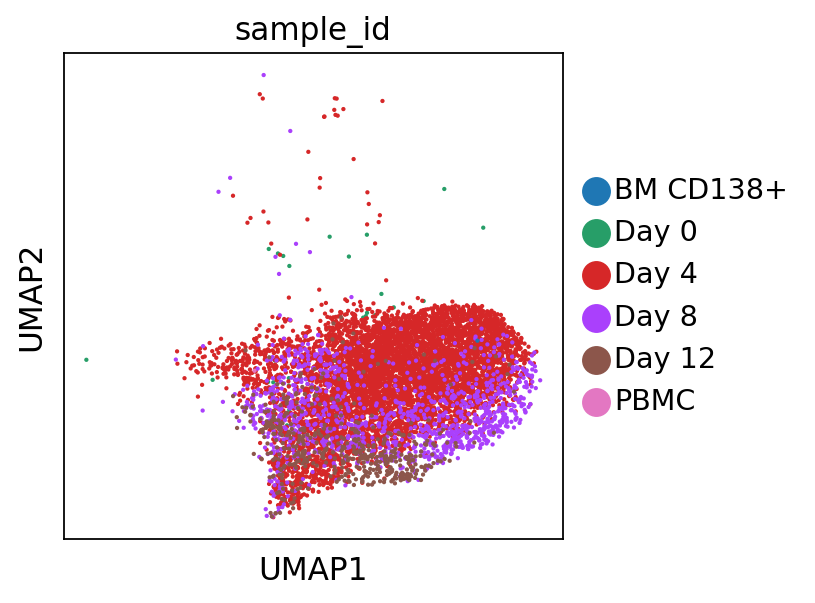

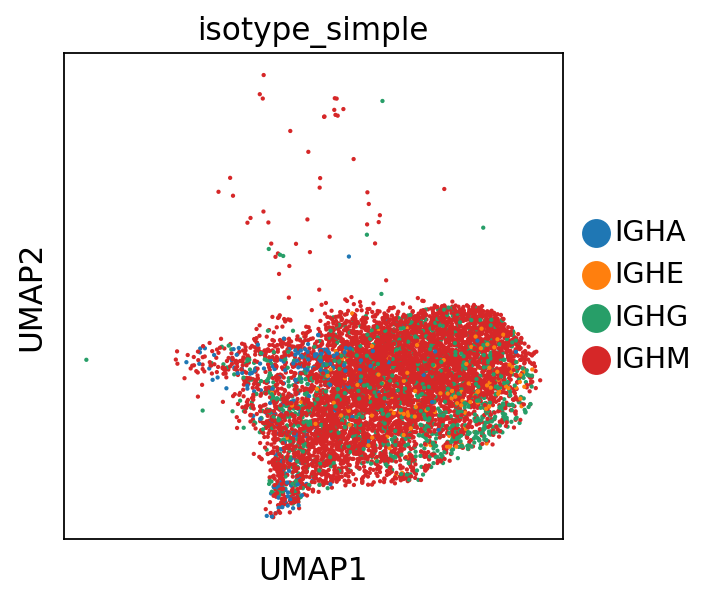

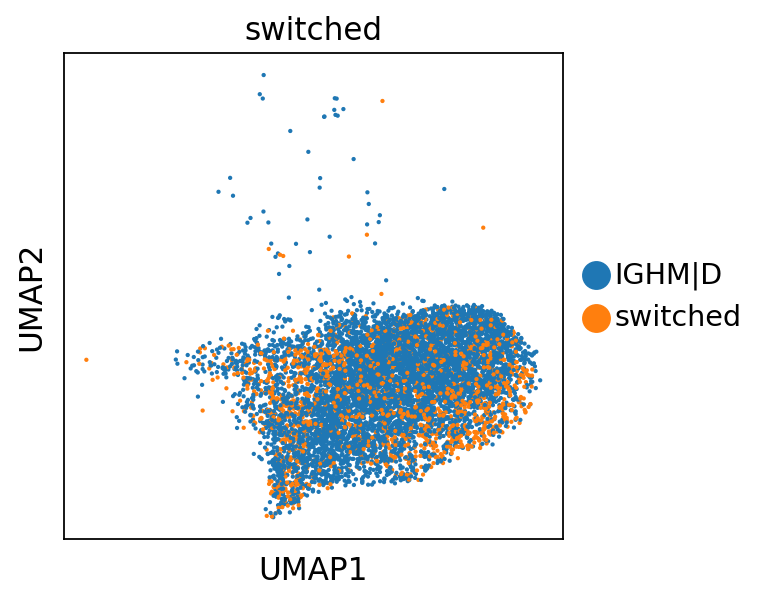

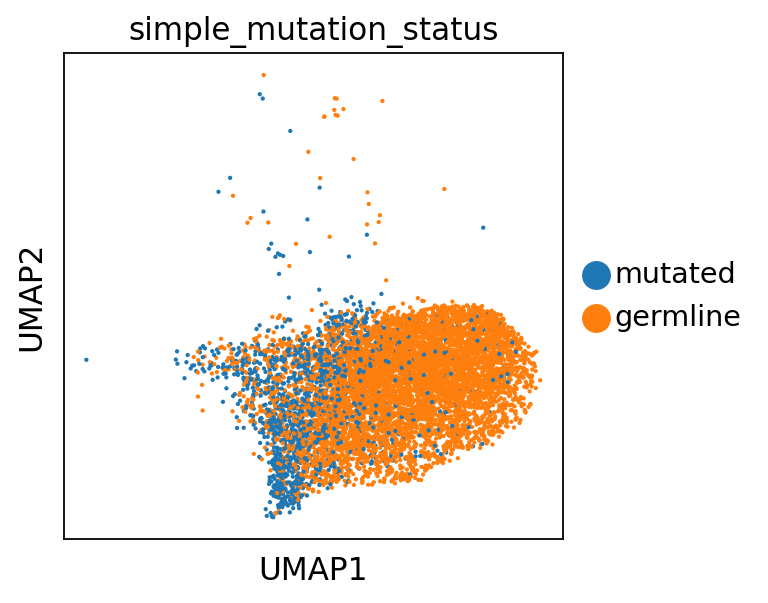

In [12]:
subset_adata, DE = DE_analysis(
    adata, "bcelltype", "Prolif. GC B cells", "isotype_simple"
)